# Determining the Usefulness of CDC Data for Disease Risk Prediction:


## An exploratory dive into CDC Survey Data

In this project, we will first extract and combine the datasets we need for our project. We will then pre-process this data, explore it, develop risk scores, do some more EDA, implement some ML models on predicting risk scores and analyse the results. 

In order to do this, the bigger dataset will be split, and pre-processing will be done separately. Finally, these datasets will be merged again for risk score generation and model implementation. 

### Data Extraction

In [1]:
import pandas as pd
import glob
import os
import seaborn as sns
#Data downloaded from https://wwwn.cdc.gov/nchs/nhanes/continuousnhanes/default.aspx?BeginYear=2017
#using terminal, convert .xtp files to .csv and upload to deepnote 
#pip install xport
#cd to Downloads directory
#python -m xport fild.xtp > file.csv

In [2]:
#Combine csv's for analysis: demographics, alcohol use, diet behavior nutrition, drug use, depression screener, physical functioning
csv_files = ['/work/ALQ_J.csv','/work/DBQ_J.csv', '/work/DUQ_J.csv', '/work/DPQ_J.csv', '/work/PFQ_J.csv']

#Need a populated dataframe to use merge on SEQN, so start with Demographics csv.
df_merged = pd.read_csv('/work/DEMO_J.csv')
#merge all files together
for file in csv_files:
    df_temp = pd.read_csv(file)
    df_merged = df_merged.merge(df_temp, on = 'SEQN', how = 'outer')
#185 columns

In [3]:
#Cut the df down to only the colums we are interested in. 
dem_list = ['SEQN','RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'RIDRETH3', 'DMQMILIZ', 'DMQADFC', 'DMDBORN4','DMDCITZN', 'DMDYRSUS', 'DMDEDUC3', 'DMDEDUC2', 'DMDMARTL', 'DMDHHSIZ', 'DMDFMSIZ', 'DMDHHSZA', 'DMDHHSZE', 'INDHHIN2', 'INDFMIN2', 'INDFMPIR']

dem_list_short = ['SEQN','RIAGENDR', 'RIDRETH1', 'DMQMILIZ', 'DMDEDUC2', 'DMDHHSIZ', 'DMDFMSIZ', 'INDHHIN2', 'INDFMIN2']
alc_list = ['ALQ121', 'ALQ130', 'ALQ142', 'ALQ270', 'ALQ280', 'ALQ290', 'ALQ170']
dbn_list = ['DBQ700', 'DBQ301', 'DBQ330', 'DBD381', 'DBD411', 'DBD895', 'DBD900', 'DBD905', 'DBD910']
dep_list = ['DPQ010', 'DPQ020', 'DPQ030', 'DPQ040', 'DPQ050', 'DPQ060', 'DPQ070', 'DPQ080', 'DPQ090', 'DPQ100']
drug_list = ['DUQ213', 'DUQ230', 'DUQ260', 'DUQ272', 'DUQ280', 'DUQ320', 'DUQ352', 'DUQ360', 'DUQ370', 'DUQ380A', 'DUQ380B', 'DUQ380C', 'DUD380F', 'DUQ410', 'DUQ420', 'DUQ430']
phys_list = ['PFQ049', 'PFQ051', 'PFQ057', 'PFQ061A', 'PFQ061B', 'PFQ061C', 'PFQ061D', 'PFQ061E', 'PFQ061F', 'PFQ061G', 'PFQ061H', 'PFQ061I', 'PFQ061J', 'PFQ061K', 'PFQ061L', 'PFQ061M', 'PFQ061N', 'PFQ061O', 'PFQ061P', 'PFQ061Q', 'PFQ061R', 'PFQ061S', 'PFQ061T']
column_titles = dem_list + alc_list + dbn_list + drug_list + phys_list + dep_list
data = df_merged[column_titles]
data

,SEQN,RIAGENDR,RIDAGEYR,RIDRETH1,RIDRETH3,DMQMILIZ,DMQADFC,DMDBORN4,DMDCITZN,DMDYRSUS,...,DPQ010,DPQ020,DPQ030,DPQ040,DPQ050,DPQ060,DPQ070,DPQ080,DPQ090,DPQ100
0,93703.0,2.0,2.0,5.0,6.0,NaN,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,93704.0,1.0,2.0,3.0,3.0,NaN,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,93705.0,2.0,66.0,4.0,4.0,2.0,NaN,1.0,1.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,93706.0,1.0,18.0,5.0,6.0,2.0,NaN,1.0,1.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,93707.0,1.0,13.0,5.0,7.0,NaN,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9249,102952.0,2.0,70.0,5.0,6.0,2.0,NaN,2.0,1.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
9250,102953.0,1.0,42.0,1.0,1.0,2.0,NaN,2.0,2.0,77.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
9251,102954.0,2.0,41.0,4.0,4.0,2.0,NaN,1.0,1.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
9252,102955.0,2.0,14.0,4.0,4.0,NaN,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data Pre-processing part 1

First let us check the dimensions of the raw data

In [4]:
print(data.shape)

(9254, 85)


Let us check for the number of null values per row. These values indicate how many out of 85 questions went unanswered by each participant

In [5]:
# count null values per row
null_counts = data.isnull().sum(axis=1)

# print the resulting counts
print(null_counts)

0       67
1       68
2       24
3       57
4       64
        ..
9249    27
9250    42
9251    31
9252    64
9253    24
Length: 9254, dtype: int64


Let us check the mean number of questions that went unanswered so that anyone who answered less than this number of questions can be eliminated

In [6]:
null_counts_per_row = data.isnull().sum(axis=1)
avg_null_counts_per_row = null_counts_per_row.mean()

print(avg_null_counts_per_row)

47.44499675815863


Turns out that on average, more than quarter the questions have missing values. Let us discard those rows.

In [7]:
# drop rows with more than 25 null value
data_drop = data.dropna(thresh=25)

# print the resulting DataFrame
data_drop


,SEQN,RIAGENDR,RIDAGEYR,RIDRETH1,RIDRETH3,DMQMILIZ,DMQADFC,DMDBORN4,DMDCITZN,DMDYRSUS,...,DPQ010,DPQ020,DPQ030,DPQ040,DPQ050,DPQ060,DPQ070,DPQ080,DPQ090,DPQ100
2,93705.0,2.0,66.0,4.0,4.0,2.0,NaN,1.0,1.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,93706.0,1.0,18.0,5.0,6.0,2.0,NaN,1.0,1.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
5,93708.0,2.0,66.0,5.0,6.0,2.0,NaN,2.0,1.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
6,93709.0,2.0,75.0,4.0,4.0,2.0,NaN,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,93711.0,1.0,56.0,5.0,6.0,2.0,NaN,2.0,1.0,6.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9247,102950.0,1.0,64.0,4.0,4.0,1.0,2.0,1.0,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9249,102952.0,2.0,70.0,5.0,6.0,2.0,NaN,2.0,1.0,7.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
9250,102953.0,1.0,42.0,1.0,1.0,2.0,NaN,2.0,2.0,77.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
9251,102954.0,2.0,41.0,4.0,4.0,2.0,NaN,1.0,1.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [8]:
print(data_drop.shape)

(5739, 85)


Now we are left with 5739 participants who answered a good number of questions for us to make inferences. Now let us check for the null values column-wise, i.e, let us check for questions that have the least number of responses and delete those.

In [9]:

# calculate the average number of null values per column
null_counts_per_column = data_drop.isnull().sum(axis=0)
print(null_counts_per_column)


SEQN           0
RIAGENDR       0
RIDAGEYR       0
RIDRETH1       0
RIDRETH3       0
            ... 
DPQ060       648
DPQ070       648
DPQ080       648
DPQ090       649
DPQ100      2377
Length: 85, dtype: int64


In [10]:
null_counts_per_column = data_drop.isnull().sum(axis=0)
avg_null_counts_per_column = null_counts_per_column.mean()

print(avg_null_counts_per_column)

2442.2235294117645


From the above code, we can gather that, on average 2442 values are missing for each column (which is about 50 per cent of values in each column. So let us delete those columns which have more than 809 missing values

In [11]:
# drop columns with more than 809 value
data_drop = data_drop.dropna(thresh=809, axis=1)

# print the resulting DataFrame
data_drop

,SEQN,RIAGENDR,RIDAGEYR,RIDRETH1,RIDRETH3,DMQMILIZ,DMDBORN4,DMDCITZN,DMDYRSUS,DMDEDUC2,...,DPQ010,DPQ020,DPQ030,DPQ040,DPQ050,DPQ060,DPQ070,DPQ080,DPQ090,DPQ100
2,93705.0,2.0,66.0,4.0,4.0,2.0,1.0,1.0,NaN,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,93706.0,1.0,18.0,5.0,6.0,2.0,1.0,1.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
5,93708.0,2.0,66.0,5.0,6.0,2.0,2.0,1.0,7.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
6,93709.0,2.0,75.0,4.0,4.0,2.0,1.0,1.0,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,93711.0,1.0,56.0,5.0,6.0,2.0,2.0,1.0,6.0,5.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9247,102950.0,1.0,64.0,4.0,4.0,1.0,1.0,1.0,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9249,102952.0,2.0,70.0,5.0,6.0,2.0,2.0,1.0,7.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
9250,102953.0,1.0,42.0,1.0,1.0,2.0,2.0,2.0,77.0,3.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
9251,102954.0,2.0,41.0,4.0,4.0,2.0,1.0,1.0,NaN,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [12]:
print(data_drop.shape)

(5739, 67)


This is our final dataset with a total of 5739 participants and 67 questions.

In [13]:
data_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5739 entries, 2 to 9253
Data columns (total 67 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   SEQN      5739 non-null   float64
 1   RIAGENDR  5739 non-null   float64
 2   RIDAGEYR  5739 non-null   float64
 3   RIDRETH1  5739 non-null   float64
 4   RIDRETH3  5739 non-null   float64
 5   DMQMILIZ  5739 non-null   float64
 6   DMDBORN4  5739 non-null   float64
 7   DMDCITZN  5736 non-null   float64
 8   DMDYRSUS  1743 non-null   float64
 9   DMDEDUC2  5495 non-null   float64
 10  DMDMARTL  5495 non-null   float64
 11  DMDHHSIZ  5739 non-null   float64
 12  DMDFMSIZ  5739 non-null   float64
 13  DMDHHSZA  5739 non-null   float64
 14  DMDHHSZE  5739 non-null   float64
 15  INDHHIN2  5436 non-null   float64
 16  INDFMIN2  5452 non-null   float64
 17  INDFMPIR  4981 non-null   float64
 18  ALQ121    4545 non-null   float64
 19  ALQ130    3495 non-null   float64
 20  ALQ142    3495 non-null   floa

In [14]:
data_drop

,SEQN,RIAGENDR,RIDAGEYR,RIDRETH1,RIDRETH3,DMQMILIZ,DMDBORN4,DMDCITZN,DMDYRSUS,DMDEDUC2,...,DPQ010,DPQ020,DPQ030,DPQ040,DPQ050,DPQ060,DPQ070,DPQ080,DPQ090,DPQ100
2,93705.0,2.0,66.0,4.0,4.0,2.0,1.0,1.0,NaN,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
3,93706.0,1.0,18.0,5.0,6.0,2.0,1.0,1.0,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
5,93708.0,2.0,66.0,5.0,6.0,2.0,2.0,1.0,7.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
6,93709.0,2.0,75.0,4.0,4.0,2.0,1.0,1.0,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,93711.0,1.0,56.0,5.0,6.0,2.0,2.0,1.0,6.0,5.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9247,102950.0,1.0,64.0,4.0,4.0,1.0,1.0,1.0,NaN,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9249,102952.0,2.0,70.0,5.0,6.0,2.0,2.0,1.0,7.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
9250,102953.0,1.0,42.0,1.0,1.0,2.0,2.0,2.0,77.0,3.0,...,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
9251,102954.0,2.0,41.0,4.0,4.0,2.0,1.0,1.0,NaN,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [15]:
data_sub1= data_drop[['SEQN', 'RIAGENDR','RIDAGEYR','ALQ121', 'ALQ130','DBQ301', 'DUQ370', 'PFQ049', 'PFQ051', 'PFQ057', 'PFQ061A', 'PFQ061G', 'PFQ061J', 'PFQ061L', 'PFQ061R']]

This dataset consists of the below factors. Here I will try and figure out if the family's economic status plays any role in a person becoming an alcohol addict

RIDAGEYR- Age of the person in Years

ALQ121- How often did you drink alcohol in the past 12 months

ALQ130- Avg # of drinks/day

DBQ301- Community/govt meals delivered

'DUQ370'- Ever use a needle to illegally inject the drug

 'PFQ049'- Limitations keeping you from working

 'PFQ051',- Limited in the amount of work you can do

 'PFQ057'- Experience confusion/memory problems

 'PFQ061A'- Difficulty managing money

 'PF061G'- Difficulty preparing meals

 'PFQ061J'- Difficulty getting in and out of bed

 'PFQ061L'- Difficulty dressing yourself

'PFQ061R'- Difficulty attending social events

In [16]:
data_sub1

,SEQN,RIAGENDR,RIDAGEYR,ALQ121,ALQ130,DBQ301,DUQ370,PFQ049,PFQ051,PFQ057,PFQ061A,PFQ061G,PFQ061J,PFQ061L,PFQ061R
2,93705.0,2.0,66.0,7.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0
3,93706.0,1.0,18.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,93708.0,2.0,66.0,NaN,NaN,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
6,93709.0,2.0,75.0,NaN,NaN,2.0,NaN,1.0,1.0,2.0,1.0,2.0,2.0,1.0,4.0
8,93711.0,1.0,56.0,5.0,1.0,NaN,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9247,102950.0,1.0,64.0,NaN,NaN,2.0,NaN,2.0,1.0,2.0,3.0,1.0,2.0,2.0,2.0
9249,102952.0,2.0,70.0,0.0,NaN,2.0,NaN,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0
9250,102953.0,1.0,42.0,6.0,12.0,NaN,2.0,2.0,2.0,2.0,NaN,NaN,NaN,NaN,NaN
9251,102954.0,2.0,41.0,NaN,NaN,NaN,2.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0


In [17]:
import numpy as np
from scipy.stats import mode
new_sub1 = data_sub1.fillna(data_sub1.mode().iloc[0])

In [18]:
print(new_sub1.shape)

(5739, 15)


In [19]:
new_sub1


,SEQN,RIAGENDR,RIDAGEYR,ALQ121,ALQ130,DBQ301,DUQ370,PFQ049,PFQ051,PFQ057,PFQ061A,PFQ061G,PFQ061J,PFQ061L,PFQ061R
2,93705.0,2.0,66.0,7.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0
3,93706.0,1.0,18.0,0.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0
5,93708.0,2.0,66.0,0.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
6,93709.0,2.0,75.0,0.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0,2.0,2.0,1.0,4.0
8,93711.0,1.0,56.0,5.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9247,102950.0,1.0,64.0,0.0,1.0,2.0,2.0,2.0,1.0,2.0,3.0,1.0,2.0,2.0,2.0
9249,102952.0,2.0,70.0,0.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0
9250,102953.0,1.0,42.0,6.0,12.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0
9251,102954.0,2.0,41.0,0.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0


Data Scaling: 

All of the data will be rescaled into a scale of 0 to 5

ALQ121

#0- never                                     -> 1
#1/2/3- every/nearly every day  -> 5
#4/5/6                                           ->4
#7/8                                               ->3
#9/10                                             ->2

ALQ130

#1 to 13- number of drinks 

1/2/3                                       ->1

4/5/6                                      ->2

7/8/9                                      ->3

10/11/12/13                             ->4

#15- 15 drinks or more          ->5                                                                                                                                                       

In [20]:
replace_dict = {2:1, 3:1 ,4:2,5:2,6:2, 7:3,8:3, 9:3, 10:4, 11:4, 12:4, 13:4, 15:5,777:0,999:0}
new_sub1['ALQ130'] = new_sub1['ALQ130'].replace(replace_dict)

replace_dict = {0:1,1:5, 2:5, 3:5 ,4:4,5:4,6:4,7:3,8:3,9:2,10:2,99:0,77:0}
new_sub1['ALQ121'] = new_sub1['ALQ121'].replace(replace_dict)

replace_dict = {5:0, 3:4,4:5,7:0,9:0}
new_sub1['PFQ061A'] = new_sub1['PFQ061A'].replace(replace_dict)
replace_dict = {5:0, 3:4,4:5,7:0,9:0}
new_sub1['PFQ061R'] = new_sub1['PFQ061R'].replace(replace_dict)
replace_dict = {5:0, 3:4,4:5,7:0,9:0}
new_sub1['PFQ061J'] = new_sub1['PFQ061J'].replace(replace_dict)
replace_dict = {5:0, 3:4,4:5,7:0,9:0}
new_sub1['PFQ061G'] = new_sub1['PFQ061G'].replace(replace_dict)
replace_dict = {5:0, 3:4,4:5,7:0,9:0}
new_sub1['PFQ061L'] = new_sub1['PFQ061L'].replace(replace_dict)


replace_dict = {7:0,9:0}
new_sub1['DBQ301'] = new_sub1['DBQ301'].replace(replace_dict)
replace_dict = {7:0,9:0}
new_sub1['DUQ370'] = new_sub1['DUQ370'].replace(replace_dict)

replace_dict = {7:0,9:0}
new_sub1['PFQ049'] = new_sub1['PFQ049'].replace(replace_dict)
replace_dict = {7:0,9:0}
new_sub1['PFQ051'] = new_sub1['PFQ051'].replace(replace_dict)
replace_dict = {7:0,9:0}
new_sub1['PFQ057'] = new_sub1['PFQ057'].replace(replace_dict)

replace_dict = {0:1,7777:0, 9999:0,5555:5}
new_sub1['RIDAGEYR'] = new_sub1['RIDAGEYR'].replace(replace_dict)
old_vals = {range(0,17)}
new_val = 1
replace_dict = {x: new_val for x in old_vals}
new_sub1['RIDAGEYR'] = new_sub1['RIDAGEYR'].replace(replace_dict)
old_vals1 = {range(17,33)}
new_val1 = 2
replace_dict1= {x: new_val1 for x in old_vals1}
new_sub1['RIDAGEYR'] = new_sub1['RIDAGEYR'].replace(replace_dict1)
old_vals2 = {range(33,49)}
new_val2 = 3
replace_dict2 = {x: new_val2 for x in old_vals2}
new_sub1['RIDAGEYR'] = new_sub1['RIDAGEYR'].replace(replace_dict2)
old_vals3 = {range(49,65)}
new_val3 = 4
replace_dict3 = {x: new_val3 for x in old_vals3}
new_sub1['RIDAGEYR'] = new_sub1['RIDAGEYR'].replace(replace_dict3)
old_vals4 = {range(65,120)}
new_val4 = 5
replace_dict4 = {x: new_val4 for x in old_vals4}
new_sub1['RIDAGEYR'] = new_sub1['RIDAGEYR'].replace(replace_dict4)

new_sub1


,SEQN,RIAGENDR,RIDAGEYR,ALQ121,ALQ130,DBQ301,DUQ370,PFQ049,PFQ051,PFQ057,PFQ061A,PFQ061G,PFQ061J,PFQ061L,PFQ061R
2,93705.0,2.0,5.0,3.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0
3,93706.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0
5,93708.0,2.0,5.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
6,93709.0,2.0,5.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0,2.0,2.0,1.0,5.0
8,93711.0,1.0,4.0,4.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9247,102950.0,1.0,4.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,4.0,1.0,2.0,2.0,2.0
9249,102952.0,2.0,5.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0
9250,102953.0,1.0,3.0,4.0,4.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0
9251,102954.0,2.0,3.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0


### Exploratory Data Analysis

In this section, we will try to find correlations between various attributes to help us with our analysis. We will also plot different relationships between various attributes in this dataset 

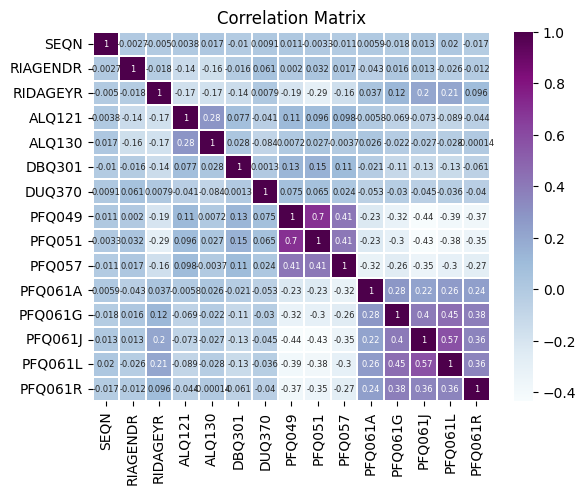

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# calculate the correlation matrix
corr_matrix = new_sub1.corr()

# change the color scheme of the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='BuPu',annot_kws={"size": 6}, linewidths=0.01)
plt.title('Correlation Matrix')
plt.show()

Developing new evidence to talk about the correlation between attributes 

In [22]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency


# Define a function to calculate Cramer's V statistic
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


# Calculate Cramer's V for two columns
corr1 = cramers_v(new_sub1['ALQ121'], new_sub1['RIDAGEYR'])
print(corr1)

corr2 = cramers_v(new_sub1['ALQ130'], new_sub1['RIDAGEYR'])
print(corr2)

corr3 = cramers_v(new_sub1['DUQ370'], new_sub1['RIDAGEYR'])
print(corr1)

0.1369518689947667
0.11024159215176563
0.1369518689947667


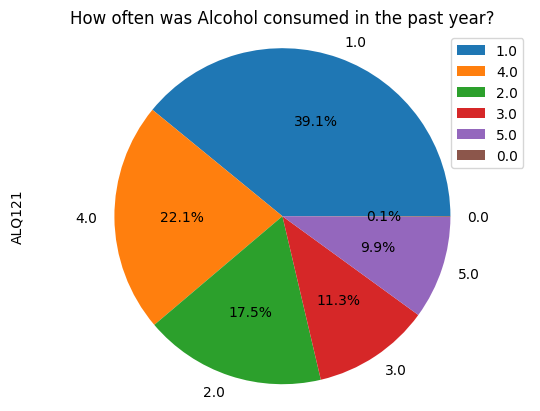

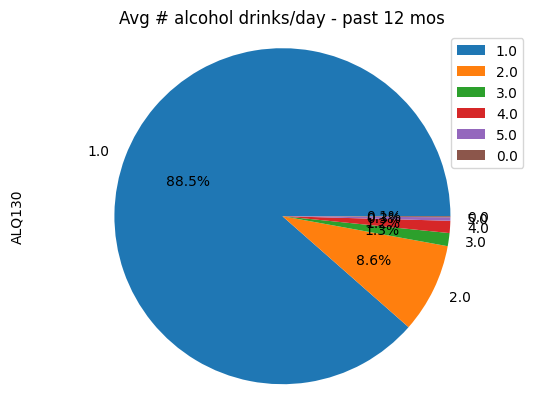

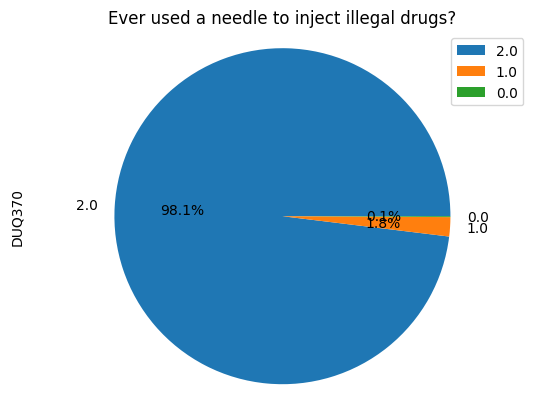

In [23]:
# create a frequency table for the Favorite_Color column
freq_table_121 = new_sub1['ALQ121'].value_counts()

# create a pie chart of the Favorite_Color column
freq_table_121.plot(kind='pie', legend=True, autopct='%1.1f%%')
plt.title('How often was Alcohol consumed in the past year?')
plt.axis('equal')
plt.show()

# create a frequency table for the Favorite_Color column
freq_table_130 = new_sub1['ALQ130'].value_counts()

# create a pie chart of the Favorite_Color column
freq_table_130.plot(kind='pie', legend=True, autopct='%1.1f%%')
plt.title('Avg # alcohol drinks/day - past 12 mos')
plt.axis('equal')
plt.show()

# create a frequency table for the Favorite_Color column
freq_table_370 = new_sub1['DUQ370'].value_counts()

# create a pie chart of the Favorite_Color column
freq_table_370.plot(kind='pie', legend=True, autopct='%1.1f%%')
plt.title('Ever used a needle to inject illegal drugs?')
plt.axis('equal')
plt.show()

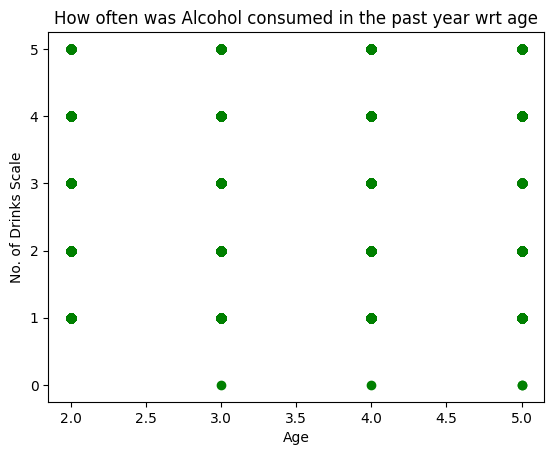

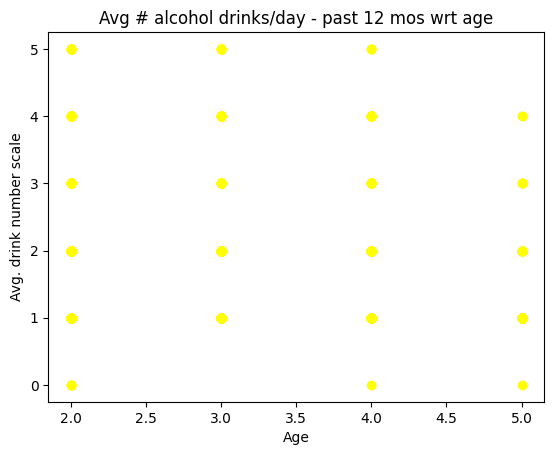

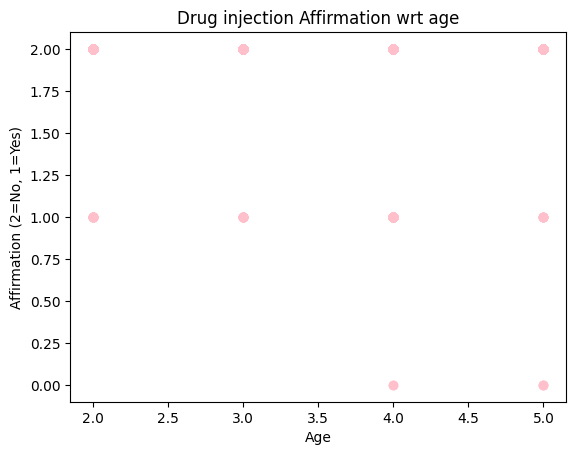

In [24]:
import matplotlib.pyplot as plt

y = new_sub1['ALQ121']
x = new_sub1['RIDAGEYR']
# Create scatter plot
plt.scatter(x, y, c='green')
# Add title and axis labels
plt.title('How often was Alcohol consumed in the past year wrt age')
plt.xlabel('Age')
plt.ylabel('No. of Drinks Scale')
# Show the plot
plt.show()

y = new_sub1['ALQ130']
x = new_sub1['RIDAGEYR']
# Create scatter plot
plt.scatter(x, y, c='yellow')
# Add title and axis labels
plt.title('Avg # alcohol drinks/day - past 12 mos wrt age')
plt.xlabel('Age')
plt.ylabel('Avg. drink number scale')
# Show the plot
plt.show()

y = new_sub1['DUQ370']
x = new_sub1['RIDAGEYR']
# Create scatter plot
plt.scatter(x, y, c='pink')
# Add title and axis labels
plt.title('Drug injection Affirmation wrt age')
plt.xlabel('Age')
plt.ylabel('Affirmation (2=No, 1=Yes)')
# Show the plot
plt.show()

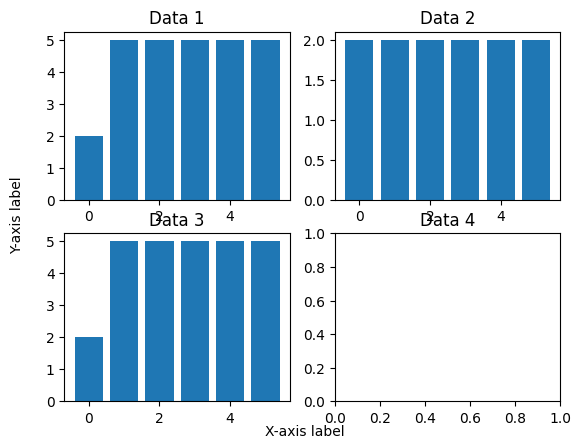

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and a grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=2)

c1= new_sub1['ALQ121']
c2= new_sub1['PFQ061R']

c3= new_sub1['PFQ057']
c4= new_sub1['PFQ061A']

# Plot the data on each subplot
axes[0, 0].bar(c1, c2)
axes[0, 1].bar(c1, c3)
axes[1, 0].bar(c1, c4)


# Set the titles for each subplot
axes[0, 0].set_title('Data 1')
axes[0, 1].set_title('Data 2')
axes[1, 0].set_title('Data 3')
axes[1, 1].set_title('Data 4')

# Add a common x-axis label and a common y-axis label
fig.text(0.5, 0.04, 'X-axis label', ha='center')
fig.text(0.04, 0.5, 'Y-axis label', va='center', rotation='vertical')

# Show the plot
plt.show()


l 

### Data Collection Part 2:

In [26]:
#combining lists of diet, alcohol and sequence number 
seq_list= ['SEQN']
diet_list=seq_list + alc_list + dbn_list 

#removing columns that crossed the missing value threshold
items_to_remove=['ALQ290', 'ALQ280', 'DBD411', 'DBD381', 'ALQ270']
diet_list = [item for item in diet_list if item not in items_to_remove]

#creating dataset using the new list
diet_df1=data_drop[diet_list]
diet_df=diet_df1.copy()

#reseeting the index to start from 0
diet_df = diet_df.reset_index(drop=True)
diet_df


,SEQN,ALQ121,ALQ130,ALQ142,ALQ170,DBQ700,DBQ301,DBQ330,DBD895,DBD900,DBD905,DBD910
0,93705.0,7.0,1.0,0.0,5.0,3.0,2.0,2.0,5.0,0.0,0.0,0.0
1,93706.0,NaN,NaN,NaN,NaN,2.0,NaN,NaN,6.0,3.0,0.0,0.0
2,93708.0,NaN,NaN,NaN,NaN,1.0,2.0,2.0,2.0,0.0,4.0,0.0
3,93709.0,NaN,NaN,NaN,NaN,3.0,2.0,2.0,0.0,NaN,2.0,1.0
4,93711.0,5.0,1.0,0.0,0.0,2.0,NaN,NaN,4.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5734,102950.0,NaN,NaN,NaN,NaN,3.0,2.0,2.0,5.0,4.0,0.0,0.0
5735,102952.0,0.0,NaN,NaN,NaN,1.0,2.0,1.0,2.0,0.0,0.0,1.0
5736,102953.0,6.0,12.0,6.0,0.0,5.0,NaN,NaN,10.0,10.0,10.0,3.0
5737,102954.0,NaN,NaN,NaN,NaN,3.0,NaN,NaN,0.0,NaN,0.0,0.0


### Data pre-processing part 2

For pre-processing, we will check for missing values and use imputation methods to fill them. For my analysis, I am imputing the missing values in a row with the mode of all the values in that row. DISCLAIMER: Here, I am assuming that the missing values are missing completely at random (MCAR).

In [27]:
#filling/imputing missing values in each row with the mode of that row
diet_df = diet_df.apply(lambda x: x.fillna(x.mode()[0]), axis=0)
diet_df

,SEQN,ALQ121,ALQ130,ALQ142,ALQ170,DBQ700,DBQ301,DBQ330,DBD895,DBD900,DBD905,DBD910
0,93705.0,7.0,1.0,0.0,5.0,3.0,2.0,2.0,5.0,0.0,0.0,0.0
1,93706.0,0.0,1.0,0.0,0.0,2.0,2.0,2.0,6.0,3.0,0.0,0.0
2,93708.0,0.0,1.0,0.0,0.0,1.0,2.0,2.0,2.0,0.0,4.0,0.0
3,93709.0,0.0,1.0,0.0,0.0,3.0,2.0,2.0,0.0,0.0,2.0,1.0
4,93711.0,5.0,1.0,0.0,0.0,2.0,2.0,2.0,4.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5734,102950.0,0.0,1.0,0.0,0.0,3.0,2.0,2.0,5.0,4.0,0.0,0.0
5735,102952.0,0.0,1.0,0.0,0.0,1.0,2.0,1.0,2.0,0.0,0.0,1.0
5736,102953.0,6.0,12.0,6.0,0.0,5.0,2.0,2.0,10.0,10.0,10.0,3.0
5737,102954.0,0.0,1.0,0.0,0.0,3.0,2.0,2.0,0.0,0.0,0.0,0.0


In [28]:
print(diet_df.shape)

(5739, 12)


Now I will scale all the survey data into 1-5

In [29]:
replace_dict = {2:1, 3:1 ,4:2,5:2,6:2, 7:3,8:3, 9:3, 10:4, 11:4, 12:4, 13:4, 15:5,777:0,999:0}
diet_df['ALQ130'] = diet_df['ALQ130'].replace(replace_dict)

replace_dict = {0:1,1:5, 2:5, 3:5 ,4:4,5:4,6:4,7:3,8:3,9:2,10:2,99:0,77:0}
diet_df['ALQ121'] = diet_df['ALQ121'].replace(replace_dict)

replace_dict = {0:1,1:5, 2:5, 3:5 ,4:4,5:4,6:4,7:3,8:3,9:2,10:2,99:0,77:0}
diet_df['ALQ142'] = diet_df['ALQ142'].replace(replace_dict)

old_vals = {0,1, 2, 3, 4,5}
new_val = 1
replace_dict = {x: new_val for x in old_vals}
diet_df['ALQ170'] = diet_df['ALQ170'].replace(replace_dict)

old_vals = {6, 7, 8, 9,10}
new_val = 2
replace_dict = {x: new_val for x in old_vals}
diet_df['ALQ170'] = diet_df['ALQ170'].replace(replace_dict)

old_vals = {11, 12, 13, 14,15}
new_val = 3
replace_dict = {x: new_val for x in old_vals}
diet_df['ALQ170'] = diet_df['ALQ170'].replace(replace_dict)

old_vals = {16, 17, 18, 19, 20}
new_val = 4
replace_dict = {x: new_val for x in old_vals}
diet_df['ALQ170'] = diet_df['ALQ170'].replace(replace_dict)

replace_dict = {999:0,777:0,30:5}
diet_df['ALQ170'] = diet_df['ALQ170'].replace(replace_dict)


In [30]:
diet_df

,SEQN,ALQ121,ALQ130,ALQ142,ALQ170,DBQ700,DBQ301,DBQ330,DBD895,DBD900,DBD905,DBD910
0,93705.0,3.0,1.0,1.0,1.0,3.0,2.0,2.0,5.0,0.0,0.0,0.0
1,93706.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,6.0,3.0,0.0,0.0
2,93708.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,0.0,4.0,0.0
3,93709.0,1.0,1.0,1.0,1.0,3.0,2.0,2.0,0.0,0.0,2.0,1.0
4,93711.0,4.0,1.0,1.0,1.0,2.0,2.0,2.0,4.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5734,102950.0,1.0,1.0,1.0,1.0,3.0,2.0,2.0,5.0,4.0,0.0,0.0
5735,102952.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,0.0,0.0,1.0
5736,102953.0,4.0,4.0,4.0,1.0,5.0,2.0,2.0,10.0,10.0,10.0,3.0
5737,102954.0,1.0,1.0,1.0,1.0,3.0,2.0,2.0,0.0,0.0,0.0,0.0


In [31]:
#replace a set of values with a single value

replace_dict = {0:1, 7777:0, 9999:0}
diet_df['DBD910'] = diet_df['DBD910'].replace(replace_dict)

old_vals = {range(1,31)}
new_val = 2
replace_dict = {x: new_val for x in old_vals}
diet_df['DBD910'] = diet_df['DBD910'].replace(replace_dict)

old_vals1 = {range(1,61)}
new_val1 = 3
replace_dict1= {x: new_val1 for x in old_vals1}
diet_df['DBD910'] = diet_df['DBD910'].replace(replace_dict1)

old_vals2 = {range(61,91)}
new_val2 = 4
replace_dict2 = {x: new_val2 for x in old_vals2}
diet_df['DBD910'] = diet_df['DBD910'].replace(replace_dict2)

replace_dict = {6666:5}
diet_df['DBD910'] = diet_df['DBD910'].replace(replace_dict)

#replace_dict = {0:1,1: 5, 2: 5, 3:4 ,4:3,7:2}
#new_sub1['DBD905'] = new_sub1['ALQ121'].replace(replace_dict)

In [32]:
old_vals = {range(1,31)}
new_val = 2
replace_dict = {x: new_val for x in old_vals}
diet_df['DBD905'] = diet_df['DBD905'].replace(replace_dict)

old_vals1 = {range(31,61)}
new_val1 = 3
replace_dict1= {x: new_val1 for x in old_vals1}
diet_df['DBD905'] = diet_df['DBD905'].replace(replace_dict1)

old_vals2 = {range(61,91)}
new_val2 = 4
replace_dict2 = {x: new_val2 for x in old_vals2}
diet_df['DBD905'] = diet_df['DBD905'].replace(replace_dict2)

replace_dict3 = {6666:5}
diet_df['DBD905'] = diet_df['DBD905'].replace(replace_dict3)

replace_dict4 = {0:1,7777:0, 9999:0}
diet_df['DBD905'] = diet_df['DBD905'].replace(replace_dict4)

In [33]:
diet_df

,SEQN,ALQ121,ALQ130,ALQ142,ALQ170,DBQ700,DBQ301,DBQ330,DBD895,DBD900,DBD905,DBD910
0,93705.0,3.0,1.0,1.0,1.0,3.0,2.0,2.0,5.0,0.0,1.0,3.0
1,93706.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,6.0,3.0,1.0,3.0
2,93708.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,0.0,2.0,3.0
3,93709.0,1.0,1.0,1.0,1.0,3.0,2.0,2.0,0.0,0.0,2.0,3.0
4,93711.0,4.0,1.0,1.0,1.0,2.0,2.0,2.0,4.0,0.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5734,102950.0,1.0,1.0,1.0,1.0,3.0,2.0,2.0,5.0,4.0,1.0,3.0
5735,102952.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,0.0,1.0,3.0
5736,102953.0,4.0,4.0,4.0,1.0,5.0,2.0,2.0,10.0,10.0,2.0,3.0
5737,102954.0,1.0,1.0,1.0,1.0,3.0,2.0,2.0,0.0,0.0,1.0,3.0


In [34]:
replace_dict = {0:1,7777:0, 9999:0,5555:5}
diet_df['DBD895'] = diet_df['DBD895'].replace(replace_dict)
old_vals = {range(1,8)}
new_val = 2
replace_dict = {x: new_val for x in old_vals}
diet_df['DBD895'] = diet_df['DBD895'].replace(replace_dict)
old_vals1 = {range(8,17)}
new_val1 = 3
replace_dict1= {x: new_val1 for x in old_vals1}
diet_df['DBD895'] = diet_df['DBD895'].replace(replace_dict1)
old_vals2 = {range(17,22)}
new_val2 = 4
replace_dict2 = {x: new_val2 for x in old_vals2}
diet_df['DBD895'] = diet_df['DBD895'].replace(replace_dict2)

replace_dict = {0:1,7777:0, 9999:0,5555:5}
diet_df['DBD900'] = diet_df['DBD900'].replace(replace_dict)
old_vals = {range(1,8)}
new_val = 2
replace_dict = {x: new_val for x in old_vals}
diet_df['DBD900'] = diet_df['DBD900'].replace(replace_dict)
old_vals1 = {range(8,17)}
new_val1 = 3
replace_dict1= {x: new_val1 for x in old_vals1}
diet_df['DBD900'] = diet_df['DBD900'].replace(replace_dict1)
old_vals2 = {range(17,22)}
new_val2 = 4
replace_dict2 = {x: new_val2 for x in old_vals2}
diet_df['DBD900'] = diet_df['DBD900'].replace(replace_dict2)

replace_dict8 = {9:0,7:0}
diet_df['DBQ700'] = diet_df['DBQ700'].replace(replace_dict8)

In [35]:
replace_dict = {7:0,9:0}
diet_df['DBQ330'] = diet_df['DBQ330'].replace(replace_dict)
replace_dict = {7:0,9:0}
diet_df['DBQ301'] = diet_df['DBQ301'].replace(replace_dict)

In [36]:
diet_df

,SEQN,ALQ121,ALQ130,ALQ142,ALQ170,DBQ700,DBQ301,DBQ330,DBD895,DBD900,DBD905,DBD910
0,93705.0,3.0,1.0,1.0,1.0,3.0,2.0,2.0,2.0,2.0,1.0,3.0
1,93706.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,3.0
2,93708.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,3.0
3,93709.0,1.0,1.0,1.0,1.0,3.0,2.0,2.0,2.0,2.0,2.0,3.0
4,93711.0,4.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...
5734,102950.0,1.0,1.0,1.0,1.0,3.0,2.0,2.0,2.0,2.0,1.0,3.0
5735,102952.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,2.0,2.0,1.0,3.0
5736,102953.0,4.0,4.0,4.0,1.0,5.0,2.0,2.0,3.0,3.0,2.0,3.0
5737,102954.0,1.0,1.0,1.0,1.0,3.0,2.0,2.0,2.0,2.0,1.0,3.0


3. Performing statistical analysis: Use statistical methods such as logistic regression or machine learning algorithms to analyze the data and identify the factors that are most strongly associated with AUD.

In [37]:
diet_df= diet_df.drop(['ALQ121','ALQ130','DBQ301'],axis=1)

In [38]:
big_data= new_sub1.merge(diet_df, on='SEQN',how='inner')

In [39]:
big_data

,SEQN,RIAGENDR,RIDAGEYR,ALQ121,ALQ130,DBQ301,DUQ370,PFQ049,PFQ051,PFQ057,...,PFQ061L,PFQ061R,ALQ142,ALQ170,DBQ700,DBQ330,DBD895,DBD900,DBD905,DBD910
0,93705.0,2.0,5.0,3.0,1.0,2.0,2.0,2.0,2.0,2.0,...,1.0,1.0,1.0,1.0,3.0,2.0,2.0,2.0,1.0,3.0
1,93706.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,...,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,3.0
2,93708.0,2.0,5.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,3.0
3,93709.0,2.0,5.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0,...,1.0,5.0,1.0,1.0,3.0,2.0,2.0,2.0,2.0,3.0
4,93711.0,1.0,4.0,4.0,1.0,2.0,2.0,2.0,2.0,2.0,...,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,102950.0,1.0,4.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,...,2.0,2.0,1.0,1.0,3.0,2.0,2.0,2.0,1.0,3.0
5735,102952.0,2.0,5.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,...,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,3.0
5736,102953.0,1.0,3.0,4.0,4.0,2.0,2.0,2.0,2.0,2.0,...,1.0,1.0,4.0,1.0,5.0,2.0,3.0,3.0,2.0,3.0
5737,102954.0,2.0,3.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,...,1.0,1.0,1.0,1.0,3.0,2.0,2.0,2.0,1.0,3.0


In [40]:
num_big_data= big_data.drop(['SEQN'], axis=1)
num_big_data

,RIAGENDR,RIDAGEYR,ALQ121,ALQ130,DBQ301,DUQ370,PFQ049,PFQ051,PFQ057,PFQ061A,...,PFQ061L,PFQ061R,ALQ142,ALQ170,DBQ700,DBQ330,DBD895,DBD900,DBD905,DBD910
0,2.0,5.0,3.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,...,1.0,1.0,1.0,1.0,3.0,2.0,2.0,2.0,1.0,3.0
1,1.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,...,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,3.0
2,2.0,5.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,3.0
3,2.0,5.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0,...,1.0,5.0,1.0,1.0,3.0,2.0,2.0,2.0,2.0,3.0
4,1.0,4.0,4.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,...,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,1.0,4.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,4.0,...,2.0,2.0,1.0,1.0,3.0,2.0,2.0,2.0,1.0,3.0
5735,2.0,5.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,3.0
5736,1.0,3.0,4.0,4.0,2.0,2.0,2.0,2.0,2.0,1.0,...,1.0,1.0,4.0,1.0,5.0,2.0,3.0,3.0,2.0,3.0
5737,2.0,3.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,...,1.0,1.0,1.0,1.0,3.0,2.0,2.0,2.0,1.0,3.0


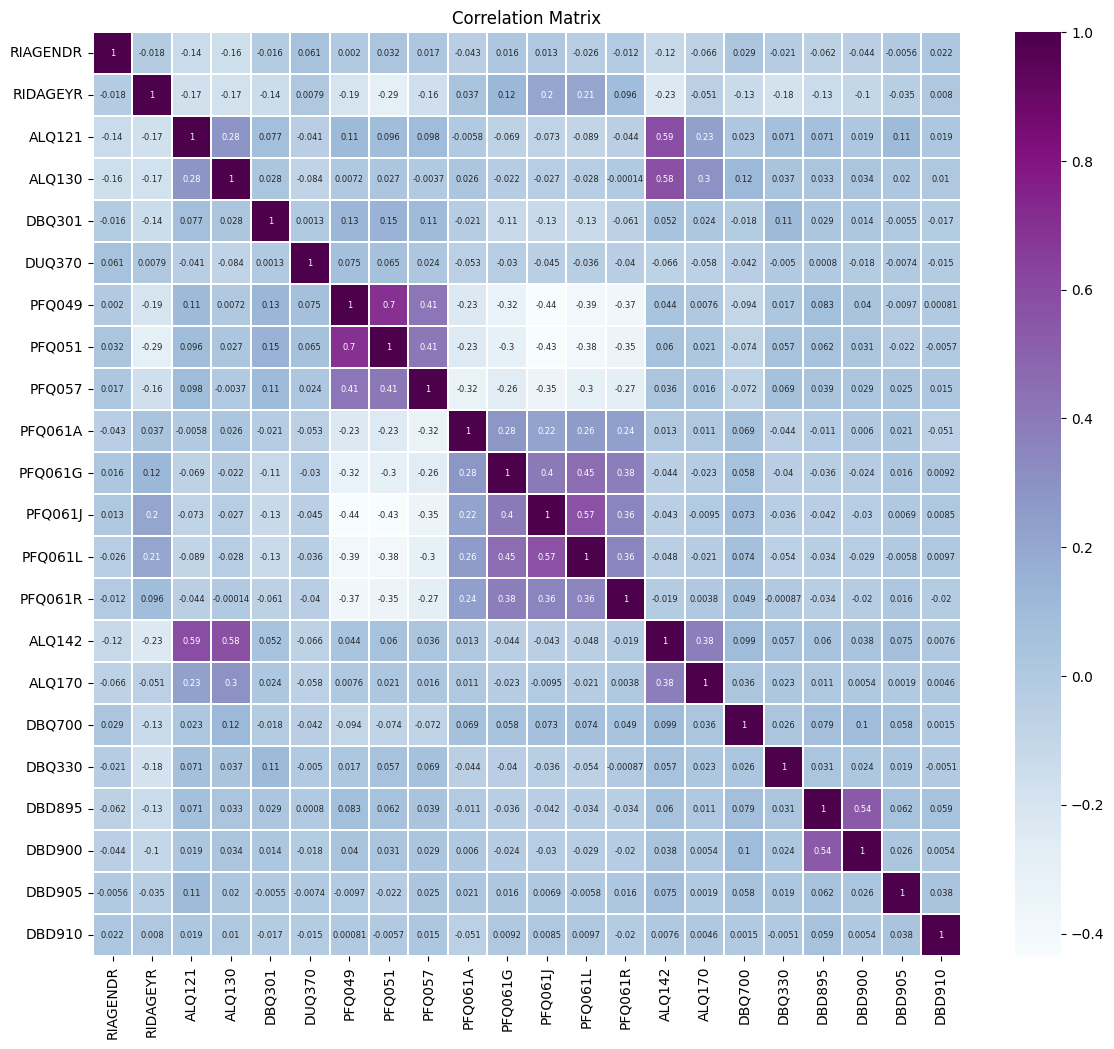

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# calculate the correlation matrix
corr_matrix = num_big_data.corr()

# Set the size of the figure
plt.figure(figsize=(14, 12))

# change the color scheme of the heatmap
sns.heatmap(corr_matrix, annot=True, cmap='BuPu',annot_kws={"size": 6}, linewidths=0.01)
plt.title('Correlation Matrix')
plt.show()

In [42]:
big_data

,SEQN,RIAGENDR,RIDAGEYR,ALQ121,ALQ130,DBQ301,DUQ370,PFQ049,PFQ051,PFQ057,...,PFQ061L,PFQ061R,ALQ142,ALQ170,DBQ700,DBQ330,DBD895,DBD900,DBD905,DBD910
0,93705.0,2.0,5.0,3.0,1.0,2.0,2.0,2.0,2.0,2.0,...,1.0,1.0,1.0,1.0,3.0,2.0,2.0,2.0,1.0,3.0
1,93706.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,...,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,3.0
2,93708.0,2.0,5.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,3.0
3,93709.0,2.0,5.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0,...,1.0,5.0,1.0,1.0,3.0,2.0,2.0,2.0,2.0,3.0
4,93711.0,1.0,4.0,4.0,1.0,2.0,2.0,2.0,2.0,2.0,...,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,102950.0,1.0,4.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,...,2.0,2.0,1.0,1.0,3.0,2.0,2.0,2.0,1.0,3.0
5735,102952.0,2.0,5.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,...,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,3.0
5736,102953.0,1.0,3.0,4.0,4.0,2.0,2.0,2.0,2.0,2.0,...,1.0,1.0,4.0,1.0,5.0,2.0,3.0,3.0,2.0,3.0
5737,102954.0,2.0,3.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,...,1.0,1.0,1.0,1.0,3.0,2.0,2.0,2.0,1.0,3.0


In [43]:

# calculate the mean of the three columns and add it to a new column
big_data['average'] = round(big_data[['ALQ121', 'ALQ130', 'ALQ142']].mean(axis=1))

# display the updated dataframe
big_data

,SEQN,RIAGENDR,RIDAGEYR,ALQ121,ALQ130,DBQ301,DUQ370,PFQ049,PFQ051,PFQ057,...,PFQ061R,ALQ142,ALQ170,DBQ700,DBQ330,DBD895,DBD900,DBD905,DBD910,average
0,93705.0,2.0,5.0,3.0,1.0,2.0,2.0,2.0,2.0,2.0,...,1.0,1.0,1.0,3.0,2.0,2.0,2.0,1.0,3.0,2.0
1,93706.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,...,1.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,3.0,1.0
2,93708.0,2.0,5.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,3.0,1.0
3,93709.0,2.0,5.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0,...,5.0,1.0,1.0,3.0,2.0,2.0,2.0,2.0,3.0,1.0
4,93711.0,1.0,4.0,4.0,1.0,2.0,2.0,2.0,2.0,2.0,...,1.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,3.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,102950.0,1.0,4.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,...,2.0,1.0,1.0,3.0,2.0,2.0,2.0,1.0,3.0,1.0
5735,102952.0,2.0,5.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,...,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,3.0,1.0
5736,102953.0,1.0,3.0,4.0,4.0,2.0,2.0,2.0,2.0,2.0,...,1.0,4.0,1.0,5.0,2.0,3.0,3.0,2.0,3.0,4.0
5737,102954.0,2.0,3.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,...,1.0,1.0,1.0,3.0,2.0,2.0,2.0,1.0,3.0,1.0


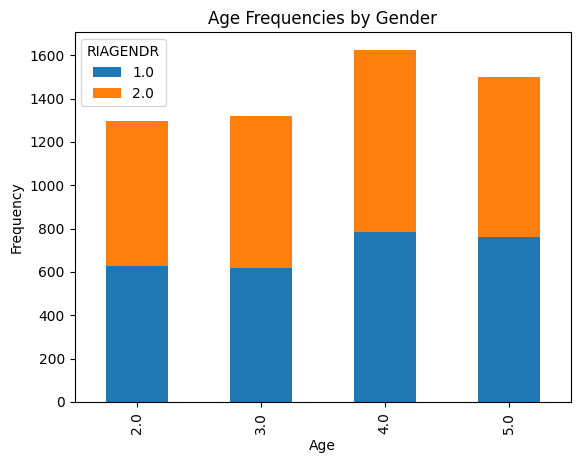

In [44]:
# Group the data by gender and age and count the values
gender_age_counts = big_data.groupby(['RIDAGEYR', 'RIAGENDR'])['RIDAGEYR'].count()

# Create a stacked bar chart using the plot() method
gender_age_counts.unstack().plot(kind='bar', stacked=True)

# Add labels and title to the plot
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Frequencies by Gender')

# Show the plot
plt.show()

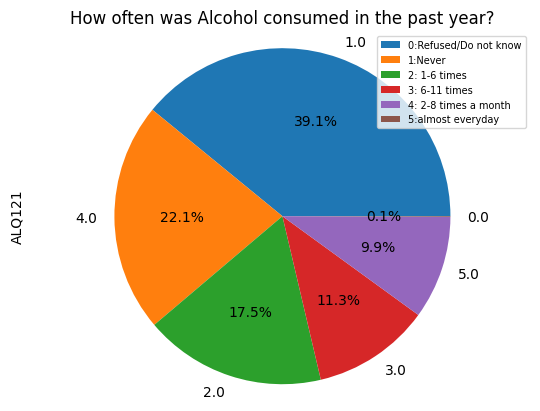

<Figure size 400x400 with 0 Axes>

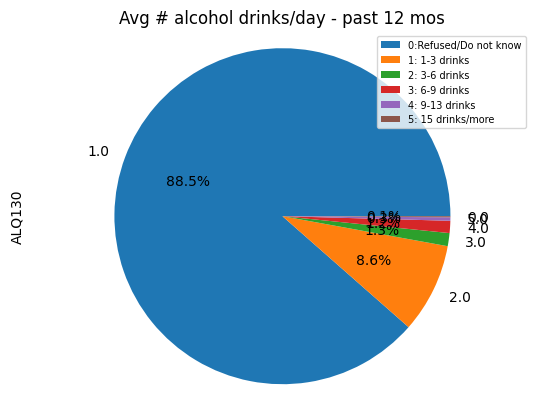

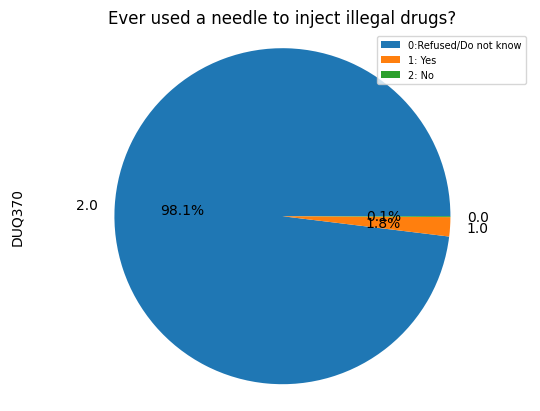

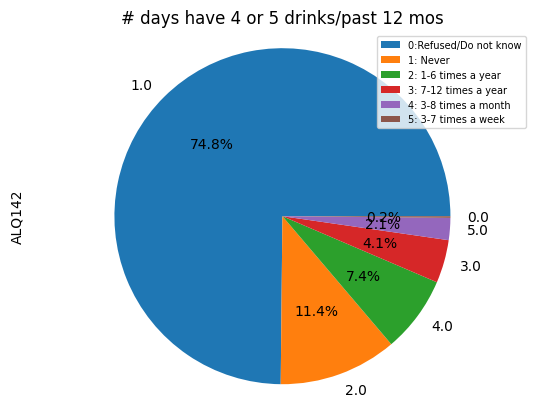

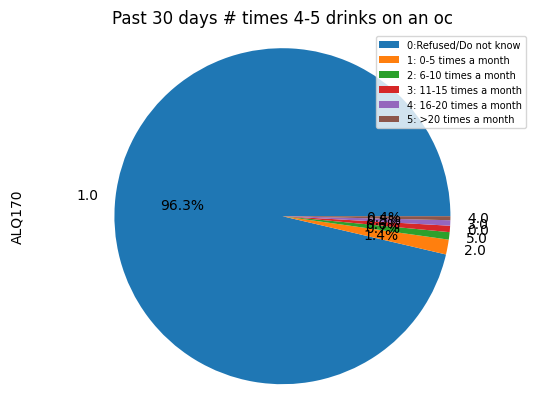

In [45]:
# create a frequency table for the Favorite_Color column
freq_table_121 = big_data['ALQ121'].value_counts()
labels_121= ['0:Refused/Do not know', '1:Never', '2: 1-6 times', '3: 6-11 times','4: 2-8 times a month','5:almost everyday']
# create a pie chart of the Favorite_Color column
freq_table_121.plot(kind='pie', legend=True, autopct='%1.1f%%')
plt.title('How often was Alcohol consumed in the past year?')
plt.axis('equal')
plt.legend(labels_121, fontsize="7",loc='upper right')
plt.figure(figsize=(4,4))
plt.show()

# create a frequency table for the Favorite_Color column
freq_table_130 = big_data['ALQ130'].value_counts()
labels_130= ['0:Refused/Do not know', '1: 1-3 drinks', '2: 3-6 drinks', '3: 6-9 drinks','4: 9-13 drinks','5: 15 drinks/more']
# create a pie chart of the Favorite_Color column
freq_table_130.plot(kind='pie', legend=True, autopct='%1.1f%%')
plt.title('Avg # alcohol drinks/day - past 12 mos')
plt.legend(labels_130, fontsize="7",loc='upper right')
plt.axis('equal')
plt.show()

# create a frequency table for the Favorite_Color column
freq_table_370 = big_data['DUQ370'].value_counts()
labels_370= ['0:Refused/Do not know', '1: Yes', '2: No']
# create a pie chart of the Favorite_Color column
freq_table_370.plot(kind='pie', legend=True, autopct='%1.1f%%')
plt.title('Ever used a needle to inject illegal drugs?')
plt.legend(labels_370, fontsize="7",loc='upper right')
plt.axis('equal')
plt.show()

# create a frequency table for the Favorite_Color column
freq_table_142 = big_data['ALQ142'].value_counts()
labels_142= ['0:Refused/Do not know', '1: Never', '2: 1-6 times a year', '3: 7-12 times a year','4: 3-8 times a month','5: 3-7 times a week']
# create a pie chart of the Favorite_Color column
freq_table_142.plot(kind='pie', legend=True, autopct='%1.1f%%')
plt.title('# days have 4 or 5 drinks/past 12 mos')
plt.legend(labels_142, fontsize="7",loc='upper right')
plt.axis('equal')
plt.show()

# create a frequency table for the Favorite_Color column
freq_table_170 = big_data['ALQ170'].value_counts()
labels_170= ['0:Refused/Do not know', '1: 0-5 times a month', '2: 6-10 times a month', '3: 11-15 times a month','4: 16-20 times a month','5: >20 times a month']
# create a pie chart of the Favorite_Color column
freq_table_170.plot(kind='pie', legend=True, autopct='%1.1f%%')
plt.title('Past 30 days # times 4-5 drinks on an oc')
plt.legend(labels_170, fontsize="7",loc='upper right')
plt.axis('equal')
plt.show()

In [46]:
# Create a correlation matrix using the corr() method
corr_matrix = num_big_data.corr()

# Select only the features with a correlation coefficient greater than 0.5
high_corr_features = corr_matrix[(corr_matrix > 0.5) & (corr_matrix != 1.0)].dropna(how='all').columns.tolist()

# Print the selected features
print(high_corr_features)

['RIAGENDR', 'RIDAGEYR', 'ALQ121', 'ALQ130', 'DBQ301', 'DUQ370', 'PFQ049', 'PFQ051', 'PFQ057', 'PFQ061A', 'PFQ061G', 'PFQ061J', 'PFQ061L', 'PFQ061R', 'ALQ142', 'ALQ170', 'DBQ700', 'DBQ330', 'DBD895', 'DBD900', 'DBD905', 'DBD910']


### Feature Selection

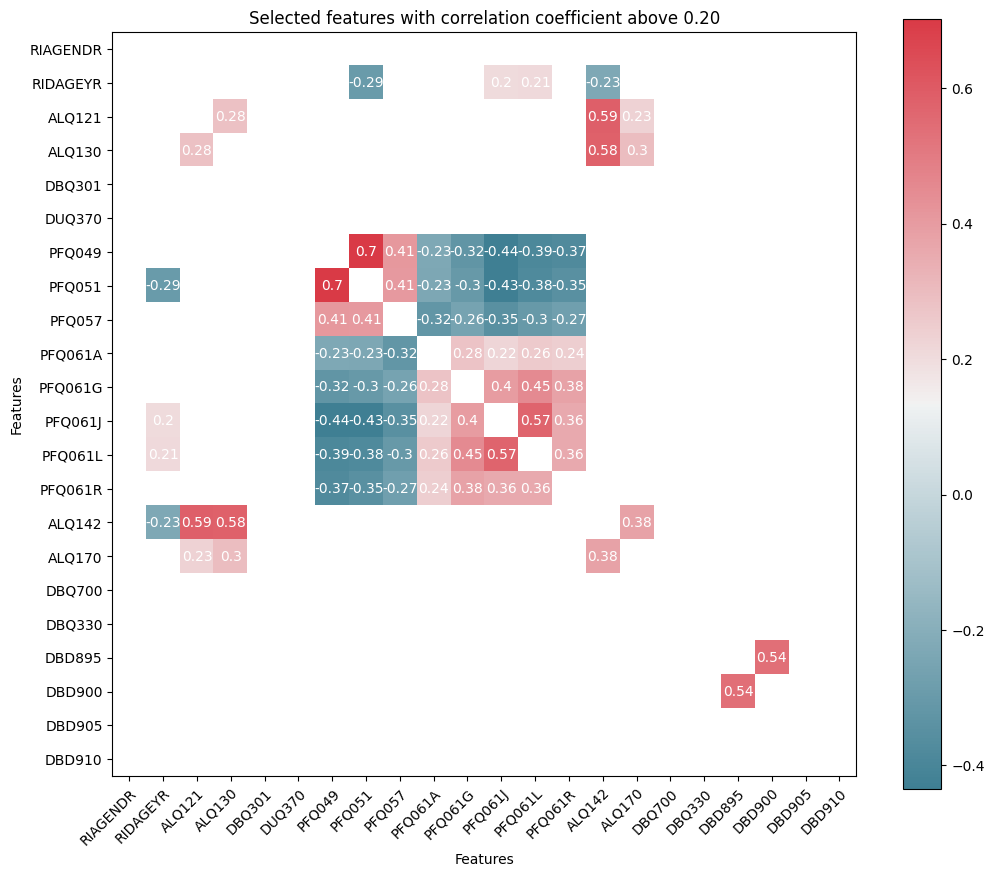

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Create a correlation matrix using the corr() method
corr_matrix = num_big_data.corr()

# Define a threshold for correlation coefficient
threshold = 0.2

# Create a matrix of selected features based on the threshold
matrix = np.where(abs(corr_matrix) >= threshold, corr_matrix, np.nan)

# Set the diagonal values to NaN to exclude self-correlations
np.fill_diagonal(matrix, np.nan)

# Define a function to set the text color based on the background color
def color_text(value):
    if np.value < 0:
        return 'black'
    else:
        return 'white'

# Set up the heatmap color scheme
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Create a heatmap of the selected features matrix using Matplotlib
fig, ax = plt.subplots(figsize=(12, 10))
im = ax.imshow(matrix, cmap=cmap)

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set tick labels and axis labels
ax.set_xticks(np.arange(len(num_big_data.columns)))
ax.set_yticks(np.arange(len(num_big_data.columns)))
ax.set_xticklabels(num_big_data.columns)
ax.set_yticklabels(num_big_data.columns)
ax.set_xlabel('Features')
ax.set_ylabel('Features')

# Rotate the tick labels and set the font size
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor", fontsize=10)
plt.setp(ax.get_yticklabels(), fontsize=10)

# Loop over data dimensions and create text annotations for non-NaN values
for i in range(len(num_big_data.columns)):
    for j in range(len(num_big_data.columns)):
        if not np.isnan(matrix[i, j]):
            text = ax.text(j, i, round(matrix[i, j], 2), ha="center", va="center", color="w", fontsize=10)

# Set the title
ax.set_title("Selected features with correlation coefficient above {:.2f}".format(threshold))

# Show the plot
plt.show()


Feature engineering based on the highest and lowest correlated attributes for each column:

In [48]:
# Iterate over columns
for col in num_big_data.columns:
    # Get correlation values for column
    corr_values = corr_matrix[col].drop(col)
    
    # Get highest and lowest correlation values
    highest_corr = corr_values.idxmax()
    lowest_corr = corr_values.idxmin()
    
    # Print results
    print(f"{col}: Highest correlation with {highest_corr} ({corr_values.loc[highest_corr]:.2f}), lowest correlation with {lowest_corr} ({corr_values.loc[lowest_corr]:.2f})")

RIAGENDR: Highest correlation with DUQ370 (0.06), lowest correlation with ALQ130 (-0.16)
RIDAGEYR: Highest correlation with PFQ061L (0.21), lowest correlation with PFQ051 (-0.29)
ALQ121: Highest correlation with ALQ142 (0.59), lowest correlation with RIDAGEYR (-0.17)
ALQ130: Highest correlation with ALQ142 (0.58), lowest correlation with RIDAGEYR (-0.17)
DBQ301: Highest correlation with PFQ051 (0.15), lowest correlation with RIDAGEYR (-0.14)
DUQ370: Highest correlation with PFQ049 (0.07), lowest correlation with ALQ130 (-0.08)
PFQ049: Highest correlation with PFQ051 (0.70), lowest correlation with PFQ061J (-0.44)
PFQ051: Highest correlation with PFQ049 (0.70), lowest correlation with PFQ061J (-0.43)
PFQ057: Highest correlation with PFQ049 (0.41), lowest correlation with PFQ061J (-0.35)
PFQ061A: Highest correlation with PFQ061G (0.28), lowest correlation with PFQ057 (-0.32)
PFQ061G: Highest correlation with PFQ061L (0.45), lowest correlation with PFQ049 (-0.32)
PFQ061J: Highest correlat

Final selection criteria attributes:

ALQ121: Highest correlation with ALQ142 (0.59), lowest correlation with RIDAGEYR (-0.17)
ALQ130: Highest correlation with ALQ142 (0.58), lowest correlation with RIDAGEYR (-0.17)

PFQ049: Highest correlation with PFQ051 (0.70), lowest correlation with PFQ061J (-0.44)
PFQ051: Highest correlation with PFQ049 (0.70), lowest correlation with PFQ061J (-0.43)

DBD895: Highest correlation with DBD900 (0.54), lowest correlation with RIDAGEYR (-0.13)
DBD900: Highest correlation with DBD895 (0.54), lowest correlation with RIDAGEYR (-0.10)

ALQ142: Highest correlation with ALQ121 (0.59), lowest correlation with RIDAGEYR (-0.23)
ALQ170: Highest correlation with ALQ142 (0.38), lowest correlation with RIAGENDR (-0.07)

### Risk Score Generation

We will develop a risk score using Logistic Regression and KNN Methods. We will then use t-SNE-based KNN to classify the participants into low, medium and high AUD risk. 

KNN-based risk score generation 

In [49]:
import pandas as pd
from sklearn.cluster import KMeans

# Select features to use for clustering
X = big_data[['RIAGENDR', 'RIDAGEYR', 'ALQ121', 'ALQ130', 'DBQ301', 'DUQ370',
       'PFQ049', 'PFQ051', 'PFQ057', 'PFQ061A', 'PFQ061G', 'PFQ061J',
       'PFQ061L', 'PFQ061R', 'ALQ142', 'ALQ170', 'DBQ700', 'DBQ330', 'DBD895',
       'DBD900', 'DBD905', 'DBD910']]

# Initialize KMeans clustering model
model = KMeans(n_clusters=3, random_state=42)

# Fit model to data
model.fit(X)

# Assign cluster labels to data
labels = model.predict(X)

# Assign risk scores to clusters
risk_scores = {
    0: "low",
    1: "medium",
    2: "high"
}
cluster_risk_scores = [risk_scores[label] for label in labels]

# Add risk score column to original dataset
num_big_data["risk_score"] = cluster_risk_scores


In [50]:
num_big_data

,RIAGENDR,RIDAGEYR,ALQ121,ALQ130,DBQ301,DUQ370,PFQ049,PFQ051,PFQ057,PFQ061A,...,PFQ061R,ALQ142,ALQ170,DBQ700,DBQ330,DBD895,DBD900,DBD905,DBD910,risk_score
0,2.0,5.0,3.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,...,1.0,1.0,1.0,3.0,2.0,2.0,2.0,1.0,3.0,medium
1,1.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,...,1.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,3.0,high
2,2.0,5.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,3.0,high
3,2.0,5.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0,...,5.0,1.0,1.0,3.0,2.0,2.0,2.0,2.0,3.0,high
4,1.0,4.0,4.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,...,1.0,1.0,1.0,2.0,2.0,2.0,2.0,1.0,3.0,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,1.0,4.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,4.0,...,2.0,1.0,1.0,3.0,2.0,2.0,2.0,1.0,3.0,high
5735,2.0,5.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,...,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,3.0,high
5736,1.0,3.0,4.0,4.0,2.0,2.0,2.0,2.0,2.0,1.0,...,1.0,4.0,1.0,5.0,2.0,3.0,3.0,2.0,3.0,low
5737,2.0,3.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,...,1.0,1.0,1.0,3.0,2.0,2.0,2.0,1.0,3.0,high


t-SNE based risk score classification

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


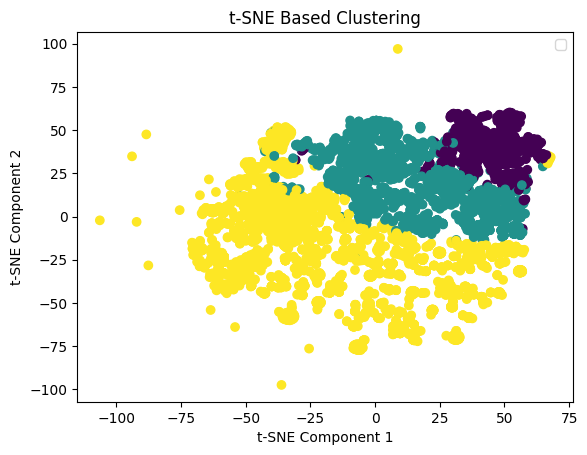

In [51]:
from sklearn.manifold import TSNE

# Apply t-SNE to reduce dimensionality of data
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X)

# Visualize clustering results using t-SNE
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Based Clustering")
plt.legend()
plt.show()

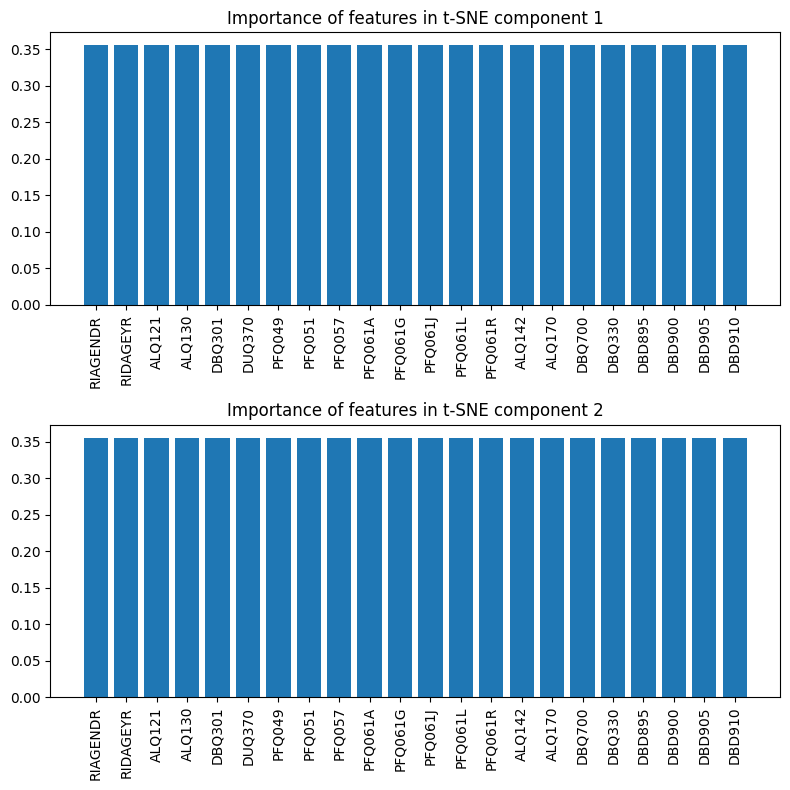

In [52]:
# Print importance of each original feature in t-SNE components
perplexity = tsne.get_params()['perplexity']
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8, 8))
axs[0].set_title('Importance of features in t-SNE component 1')
axs[0].bar(X.columns, tsne.kl_divergence_ / np.log(perplexity))
axs[0].tick_params(axis='x', rotation=90)
axs[1].set_title('Importance of features in t-SNE component 2')
axs[1].bar(X.columns, tsne.kl_divergence_ / np.log(perplexity))
axs[1].tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()


Logistic regression risk score assignment based on calculated probabilities:

In [53]:
import pandas as pd
from sklearn.linear_model import LogisticRegression

# Select features to use for logistic regression
X = num_big_data[['RIAGENDR', 'RIDAGEYR', 'ALQ121', 'ALQ130', 'DBQ301', 'DUQ370',
       'PFQ049', 'PFQ051', 'PFQ057', 'PFQ061A', 'PFQ061G', 'PFQ061J',
       'PFQ061L', 'PFQ061R', 'ALQ142', 'ALQ170', 'DBQ700', 'DBQ330', 'DBD895',
       'DBD900', 'DBD905', 'DBD910']]

# Define target variable
y = big_data['average']

# Initialize logistic regression model
model = LogisticRegression(random_state=42)

# Fit model to data
model.fit(X, y)

# Predict probability of heavy drinking for each person
probabilities = model.predict_proba(X)[:,1]

# Add probability column to original dataset
big_data["heavy_drinking_probability"] = probabilities


/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [54]:
big_data


,SEQN,RIAGENDR,RIDAGEYR,ALQ121,ALQ130,DBQ301,DUQ370,PFQ049,PFQ051,PFQ057,...,ALQ142,ALQ170,DBQ700,DBQ330,DBD895,DBD900,DBD905,DBD910,average,heavy_drinking_probability
0,93705.0,2.0,5.0,3.0,1.0,2.0,2.0,2.0,2.0,2.0,...,1.0,1.0,3.0,2.0,2.0,2.0,1.0,3.0,2.0,6.692728e-02
1,93706.0,1.0,2.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,...,1.0,1.0,2.0,2.0,2.0,2.0,1.0,3.0,1.0,9.998839e-01
2,93708.0,2.0,5.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,...,1.0,1.0,1.0,2.0,2.0,2.0,2.0,3.0,1.0,9.998781e-01
3,93709.0,2.0,5.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0,...,1.0,1.0,3.0,2.0,2.0,2.0,2.0,3.0,1.0,9.999897e-01
4,93711.0,1.0,4.0,4.0,1.0,2.0,2.0,2.0,2.0,2.0,...,1.0,1.0,2.0,2.0,2.0,2.0,1.0,3.0,2.0,3.041389e-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,102950.0,1.0,4.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,...,1.0,1.0,3.0,2.0,2.0,2.0,1.0,3.0,1.0,9.999868e-01
5735,102952.0,2.0,5.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,...,1.0,1.0,1.0,1.0,2.0,2.0,1.0,3.0,1.0,9.999135e-01
5736,102953.0,1.0,3.0,4.0,4.0,2.0,2.0,2.0,2.0,2.0,...,4.0,1.0,5.0,2.0,3.0,3.0,2.0,3.0,4.0,1.220611e-23
5737,102954.0,2.0,3.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,...,1.0,1.0,3.0,2.0,2.0,2.0,1.0,3.0,1.0,9.999496e-01


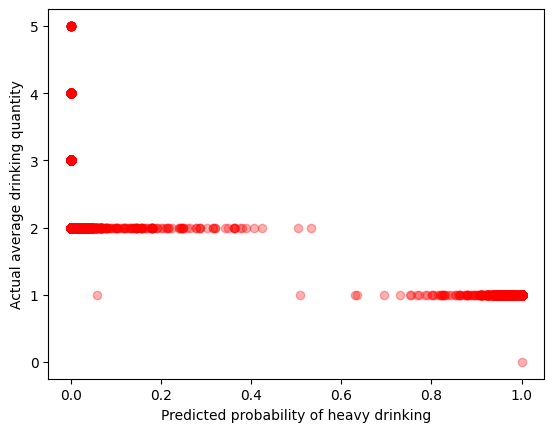

In [55]:
import matplotlib.pyplot as plt

# Plot predicted probabilities against actual values
plt.scatter(probabilities, y, alpha=0.3, color="red")
plt.xlabel("Predicted probability of heavy drinking")
plt.ylabel("Actual average drinking quantity")
plt.show()


### Post-risk score EDA

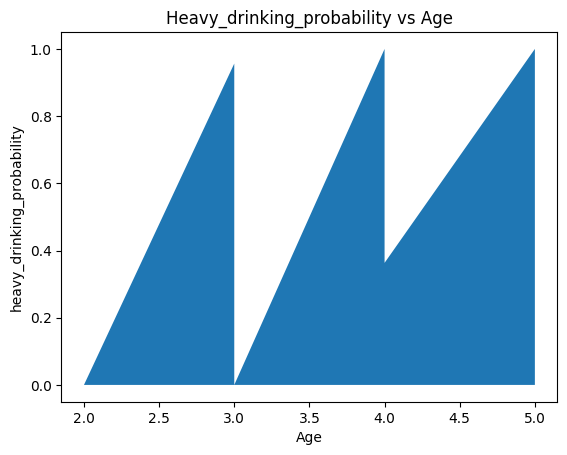

In [56]:
# Sort the data by the x-axis variable in ascending order
big_data = big_data.sort_values('RIDAGEYR')

# plot the data as a line graph
plt.fill_between(big_data['RIDAGEYR'], big_data['heavy_drinking_probability'])

# add axis labels and title
plt.xlabel('Age')
plt.ylabel('heavy_drinking_probability')
plt.title('Heavy_drinking_probability vs Age')

# display the graph
plt.show()

### ML Model Implementation

Implementing DT, RF, SVM, LR, Gradient Boost and Stacking Classifier algorithms on the original knn-based data 

Training Logistic Regression...
Accuracy for Logistic Regression: 0.9991
Confusion matrix for Logistic Regression:
[[671   0   0]
 [  0 164   1]
 [  0   0 312]]
----------------------
Training SVM...
Accuracy for SVM: 0.9826
Confusion matrix for SVM:
[[670   1   0]
 [  4 158   3]
 [ 10   2 300]]
----------------------
Training Decision Tree...
Accuracy for Decision Tree: 0.9965
Confusion matrix for Decision Tree:
[[671   0   0]
 [  0 164   1]
 [  3   0 309]]
----------------------
Training Random Forest...
Accuracy for Random Forest: 0.9983
Confusion matrix for Random Forest:
[[671   0   0]
 [  0 164   1]
 [  0   1 311]]
----------------------
Training Gradient Boost...
Accuracy for Gradient Boost: 0.9991
Confusion matrix for Gradient Boost:
[[671   0   0]
 [  0 165   0]
 [  0   1 311]]
----------------------
Training Stacked Classifier...
Accuracy for Stacked Classifier: 0.9991
Confusion matrix for Stacked Classifier:
[[671   0   0]
 [  0 164   1]
 [  0   0 312]]
---------------------

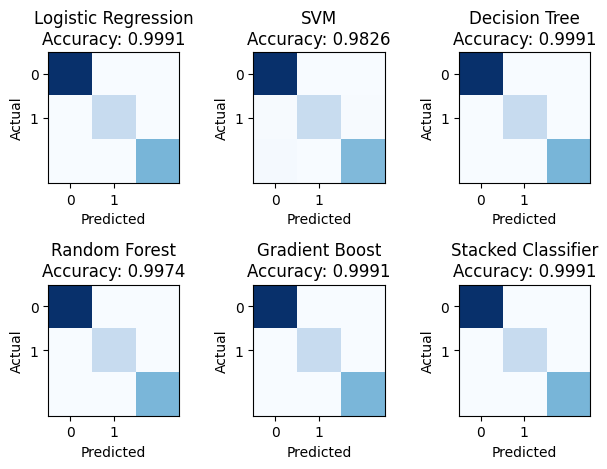

In [57]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import StackingClassifier

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(num_big_data.drop("risk_score", axis=1), num_big_data["risk_score"], test_size=0.2, random_state=42)

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define classifiers
classifiers = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('SVM', SVC()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Gradient Boost', GradientBoostingClassifier()),
    ('Stacked Classifier', StackingClassifier(estimators=[
        ('lr', LogisticRegression(max_iter=1000)),
        ('svc', SVC())
    ], final_estimator=LogisticRegression(max_iter=1000)))
]

# Evaluate classifiers
for name, clf in classifiers:
    print(f"Training {name}...")
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {name}: {acc:.4f}")
    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion matrix for {name}:")
    print(cm)
    print("----------------------")

import matplotlib.pyplot as plt

# Plot confusion matrices
for i, (name, clf) in enumerate(classifiers):
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    plt.subplot(2, 3, i+1)
    plt.title(f"{name}\nAccuracy: {acc:.4f}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.imshow(cm, cmap=plt.cm.Blues, interpolation='nearest')
    plt.xticks([0, 1], ["0", "1"])
    plt.yticks([0, 1], ["0", "1"])
    plt.tight_layout()

plt.show()


Plotting accuracy metric results: 

Training Logistic Regression...
Training SVM...
Training Decision Tree...
Training Random Forest...
Training Gradient Boost...
Training Stacked Classifier...


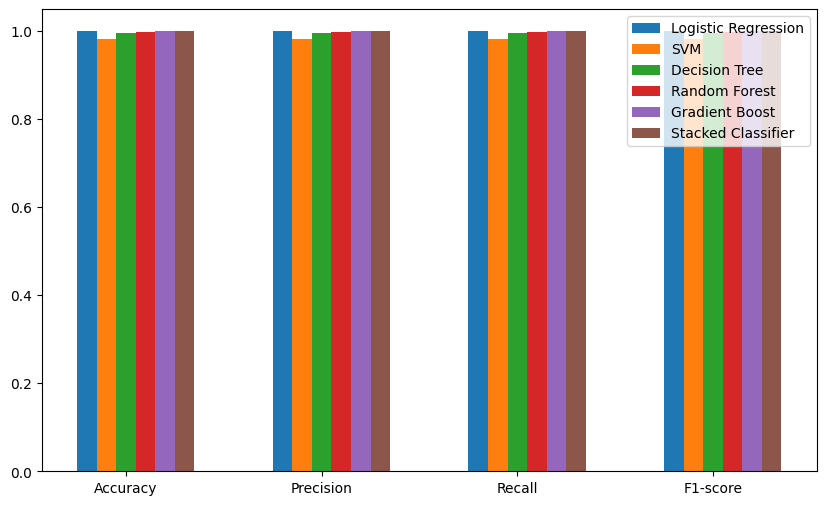

In [58]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.ensemble import StackingClassifier
import matplotlib.pyplot as plt
import numpy as np

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(num_big_data.drop("risk_score", axis=1), num_big_data["risk_score"], test_size=0.2, random_state=42)

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define classifiers
classifiers = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('SVM', SVC()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Gradient Boost', GradientBoostingClassifier()),
    ('Stacked Classifier', StackingClassifier(estimators=[
        ('lr', LogisticRegression(max_iter=1000)),
        ('svc', SVC())
    ], final_estimator=LogisticRegression(max_iter=1000)))
]

# Evaluate classifiers
accuracies = []
precisions = []
recalls = []
fscores = []

for name, clf in classifiers:
    print(f"Training {name}...")
    clf.fit(X_train_scaled, y_train)
    y_pred = clf.predict(X_test_scaled)
    accuracies.append(accuracy_score(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    precisions.append(precision)
    recalls.append(recall)
    fscores.append(fscore)

# Create grouped bar chart
labels = ['Accuracy', 'Precision', 'Recall', 'F1-score']
x = np.arange(len(labels))
width = 0.1

fig, ax = plt.subplots(figsize=(10, 6))
for i, (name, clf) in enumerate(classifiers):
    acc = accuracies[i]
    precision = precisions[i]
    recall = recalls[i]
    fscore = fscores[i]
    rects1 = ax.bar(x + i*width, [acc, precision, recall, fscore], width, label=name)

ax.set_xticks(x + 2*width)
ax.set_xticklabels(labels)
ax.legend()
plt.show()


Implementing the same models on the t-SNE-based data: 

In [59]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import StackingClassifier

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(num_big_data.drop("risk_score", axis=1), num_big_data["risk_score"], test_size=0.2, random_state=42)

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2, perplexity=50, random_state=42)
X_train_tsne = tsne.fit_transform(X_train_scaled)
X_test_tsne = tsne.fit_transform(X_test_scaled)

# Define classifiers
classifiers = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('SVM', SVC()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Gradient Boost', GradientBoostingClassifier()),
    ('Stacked Classifier', StackingClassifier(estimators=[
        ('lr', LogisticRegression(max_iter=1000)),
        ('svc', SVC())
    ], final_estimator=LogisticRegression(max_iter=1000)))
]

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [60]:
# Evaluate classifiers
for name, clf in classifiers:
    print(f"Training {name}...")
    clf.fit(X_train_tsne, y_train)
    y_pred = clf.predict(X_test_tsne)
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy for {name}: {acc:.4f}")
    cm = confusion_matrix(y_test, y_pred)
    print(f"Confusion matrix for {name}:")
    print(cm)
    print("----------------------")



Training Logistic Regression...
Accuracy for Logistic Regression: 0.5845
Confusion matrix for Logistic Regression:
[[671   0   0]
 [165   0   0]
 [312   0   0]]
----------------------
Training SVM...
Accuracy for SVM: 0.5270
Confusion matrix for SVM:
[[364 148 159]
 [ 18 145   2]
 [ 96 120  96]]
----------------------
Training Decision Tree...
Accuracy for Decision Tree: 0.5131
Confusion matrix for Decision Tree:
[[355 187 129]
 [ 33  97  35]
 [100  75 137]]
----------------------
Training Random Forest...
Accuracy for Random Forest: 0.4652
Confusion matrix for Random Forest:
[[347 147 177]
 [ 44  98  23]
 [112 111  89]]
----------------------
Training Gradient Boost...
Accuracy for Gradient Boost: 0.5322
Confusion matrix for Gradient Boost:
[[365 165 141]
 [ 16 139  10]
 [ 87 118 107]]
----------------------
Training Stacked Classifier...
Accuracy for Stacked Classifier: 0.5270
Confusion matrix for Stacked Classifier:
[[364 148 159]
 [ 18 145   2]
 [ 96 120  96]]
---------------------

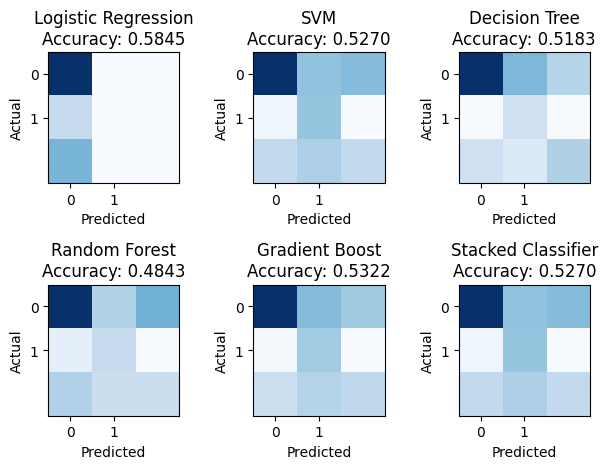

In [61]:
import matplotlib.pyplot as plt

# Plot confusion matrices
for i, (name, clf) in enumerate(classifiers):
    clf.fit(X_train_tsne, y_train)
    y_pred = clf.predict(X_test_tsne)
    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    plt.subplot(2, 3, i+1)
    plt.title(f"{name}\nAccuracy: {acc:.4f}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.imshow(cm, cmap=plt.cm.Blues, interpolation='nearest')
    plt.xticks([0, 1], ["0", "1"])
    plt.yticks([0, 1], ["0", "1"])
    plt.tight_layout()

plt.show()


Plotting accuracy metric results: 

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
Training Logistic Regression...
Training SVM...
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 

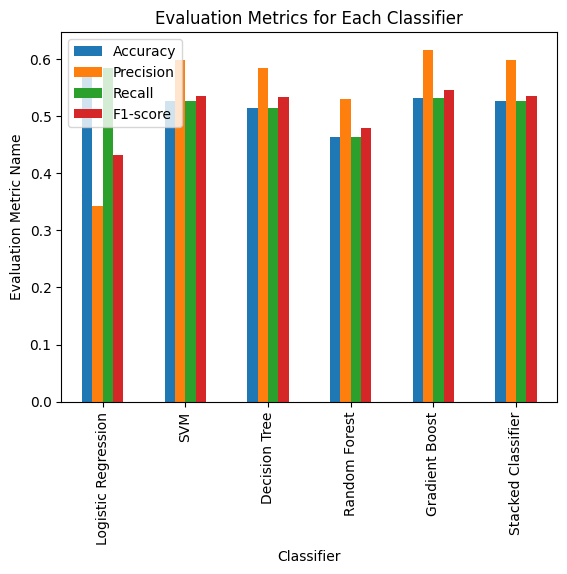

In [62]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.ensemble import StackingClassifier
import matplotlib.pyplot as plt

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(num_big_data.drop("risk_score", axis=1), num_big_data["risk_score"], test_size=0.2, random_state=42)

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reduce dimensionality using t-SNE
tsne = TSNE(n_components=2, perplexity=50, random_state=42)
X_train_tsne = tsne.fit_transform(X_train_scaled)
X_test_tsne = tsne.fit_transform(X_test_scaled)

# Define classifiers
classifiers = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('SVM', SVC()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('Random Forest', RandomForestClassifier()),
    ('Gradient Boost', GradientBoostingClassifier()),
    ('Stacked Classifier', StackingClassifier(estimators=[
        ('lr', LogisticRegression(max_iter=1000)),
        ('svc', SVC())
    ], final_estimator=LogisticRegression(max_iter=1000)))
]

# Evaluate classifiers
results = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1-score'])
for name, clf in classifiers:
    print(f"Training {name}...")
    clf.fit(X_train_tsne, y_train)
    y_pred = clf.predict(X_test_tsne)
    acc = accuracy_score(y_test, y_pred)
    precision, recall, fscore, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    results.loc[name] = [acc, precision, recall, fscore]

# Plot grouped bar chart
results.plot(kind='bar', rot=90)
plt.xlabel('Classifier')
plt.ylabel('Evaluation Metric Name')
plt.title('Evaluation Metrics for Each Classifier')
plt.show()


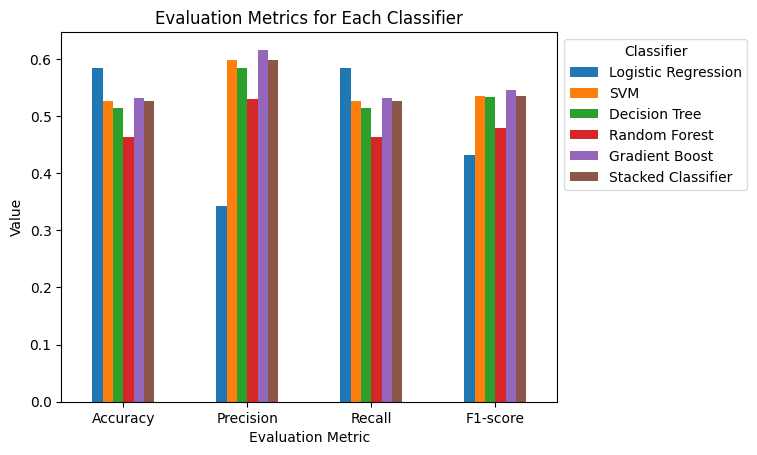

In [63]:
# Transpose DataFrame
results_df = results.T

# Plot grouped bar chart
results_df.plot(kind='bar', rot=0)
plt.legend(title='Classifier', bbox_to_anchor=(1, 1), framealpha=0.7)
plt.ylabel('Value')
plt.xlabel('Evaluation Metric')
plt.title('Evaluation Metrics for Each Classifier')

plt.show()

Refresher:

RIDAGEYR: Age in years https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/DEMO_J.htm#RIDAGEYR

SEQN: Respondent sequence number

ALQ121: https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/ALQ_J.htm#ALQ121 How often did you drink in the past 12 months

ALQ130: - Avg # alcohol drinks/day - past 12 mos https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/ALQ_J.htm#ALQ130

ALQ142: # days have 4 or 5 drinks/past 12 mos https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/ALQ_J.htm#ALQ142

ALQ170: Past 30 days # times 4-5 drinks on an oc https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/ALQ_J.htm#ALQ170

DUQ370: Ever use a needle to inject a drug? https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/DUQ_J.htm#DUQ370

DBQ301: Community/govt meals delivered https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/DBQ_J.htm#DBQ301

PFQ061G: Difficulty preparing meals https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/PFQ_J.htm#PFQ061G

DBQ330: Eat meals at comm/senior center https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/DBQ_J.htm#DBQ330

DBQ700: How healthy is your diet https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/DBQ_J.htm#DBQ700

DBD895: # of meals not home prepared https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/DBQ_J.htm#DBD895

DBD910: frozen meals/pizza in last 30 days https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/DBQ_J.htm#DBD910

DBD900: # of meals from fast food/pizza place https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/DBQ_J.htm#DBD900

DBD905: Ready to eat foods in the past 30 days https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/DBQ_J.htm#DBD905

PFQ049: Limitations keeping you from working? https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/PFQ_J.htm#PFQ049

PFQ051: Limited in the amt of work you can do https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/PFQ_J.htm#PFQ051

PFQ057: Experiencing confusion/memory problems https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/PFQ_J.htm#PFQ057

PFQ061A: Diificulty managing money. https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/PFQ_J.htm#PFQ061A

PFQ061J: Difficulty getting in and out of bed https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/PFQ_J.htm#PFQ061J

PFQ061L: difficulty dressing yourself https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/PFQ_J.htm#PFQ061L

PFQ061R: Dfficulty attending social events https://wwwn.cdc.gov/Nchs/Nhanes/2017-2018/PFQ_J.htm#PFQ061R

### Post risk-score EDA 

In [64]:
#!pip install statsmodels==0.13.5

In [65]:
big_data1=big_data
big_data1

,SEQN,RIAGENDR,RIDAGEYR,ALQ121,ALQ130,DBQ301,DUQ370,PFQ049,PFQ051,PFQ057,...,ALQ142,ALQ170,DBQ700,DBQ330,DBD895,DBD900,DBD905,DBD910,average,heavy_drinking_probability
4503,100935.0,1.0,2.0,3.0,1.0,2.0,2.0,2.0,2.0,2.0,...,1.0,1.0,1.0,2.0,3.0,3.0,1.0,3.0,2.0,2.295985e-02
3951,100003.0,2.0,2.0,4.0,1.0,2.0,2.0,2.0,2.0,2.0,...,3.0,1.0,4.0,2.0,3.0,2.0,2.0,3.0,3.0,2.628719e-10
1143,95485.0,1.0,2.0,3.0,1.0,2.0,2.0,2.0,2.0,2.0,...,1.0,1.0,1.0,2.0,4.0,2.0,1.0,3.0,2.0,8.597317e-03
1141,95481.0,1.0,2.0,3.0,1.0,2.0,2.0,2.0,2.0,2.0,...,2.0,1.0,4.0,2.0,2.0,2.0,1.0,3.0,2.0,1.593977e-04
4890,101574.0,2.0,2.0,4.0,1.0,2.0,2.0,2.0,2.0,2.0,...,3.0,1.0,3.0,2.0,2.0,2.0,2.0,3.0,3.0,2.204670e-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4288,100565.0,1.0,5.0,3.0,1.0,2.0,2.0,1.0,1.0,2.0,...,1.0,1.0,2.0,2.0,2.0,2.0,1.0,3.0,2.0,1.784453e-02
1955,96780.0,1.0,5.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,...,1.0,1.0,2.0,2.0,2.0,2.0,1.0,3.0,1.0,9.628580e-01
4285,100560.0,2.0,5.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,...,1.0,0.0,2.0,2.0,2.0,2.0,1.0,3.0,1.0,9.998851e-01
1930,96736.0,1.0,5.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,...,1.0,1.0,3.0,2.0,2.0,2.0,1.0,3.0,1.0,9.741104e-01


In [66]:
# create contingency table
contingency_table = pd.crosstab(index=[big_data['ALQ121'], big_data['DBD895']], columns=big_data['DBD905'], margins=True)

# display the contingency table
print(contingency_table)

DBD905         0.0   1.0   2.0  3.0  4.0   All
ALQ121 DBD895                                 
0.0    2.0       0     4     0    0    0     4
1.0    0.0       1     1     0    0    0     2
       2.0       8  1438   645    1    1  2093
       3.0       1    72    53    0    0   126
       4.0       0    15     7    0    0    22
2.0    0.0       0     0     2    0    0     2
       2.0       1   597   314    2    1   915
       3.0       0    39    32    0    0    71
       4.0       0     6     8    1    0    15
3.0    2.0       0   346   232    0    0   578
       3.0       0    26    29    1    0    56
       4.0       0     8     8    0    0    16
4.0    0.0       0     3     1    0    0     4
       2.0       1   657   441    2    0  1101
       3.0       0    64    66    1    0   131
       4.0       0    21    12    0    0    33
5.0    0.0       0     1     0    0    0     1
       2.0       0   281   226    4    0   511
       3.0       0    27    20    1    0    48
       4.0   

<AxesSubplot: xlabel='DBD905', ylabel='ALQ121-DBD895'>

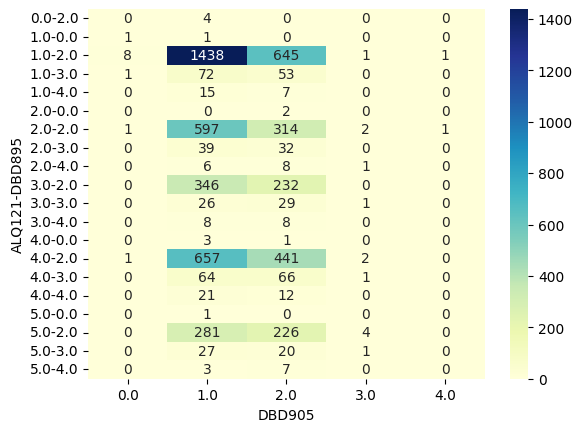

In [67]:
import pandas as pd
import seaborn as sns

# Create contingency table
cont_table = pd.crosstab(index=[big_data['ALQ121'], big_data['DBD895']], columns=big_data['DBD905'])

# Create heatmap
sns.heatmap(cont_table, cmap='YlGnBu', annot=True, fmt='g')


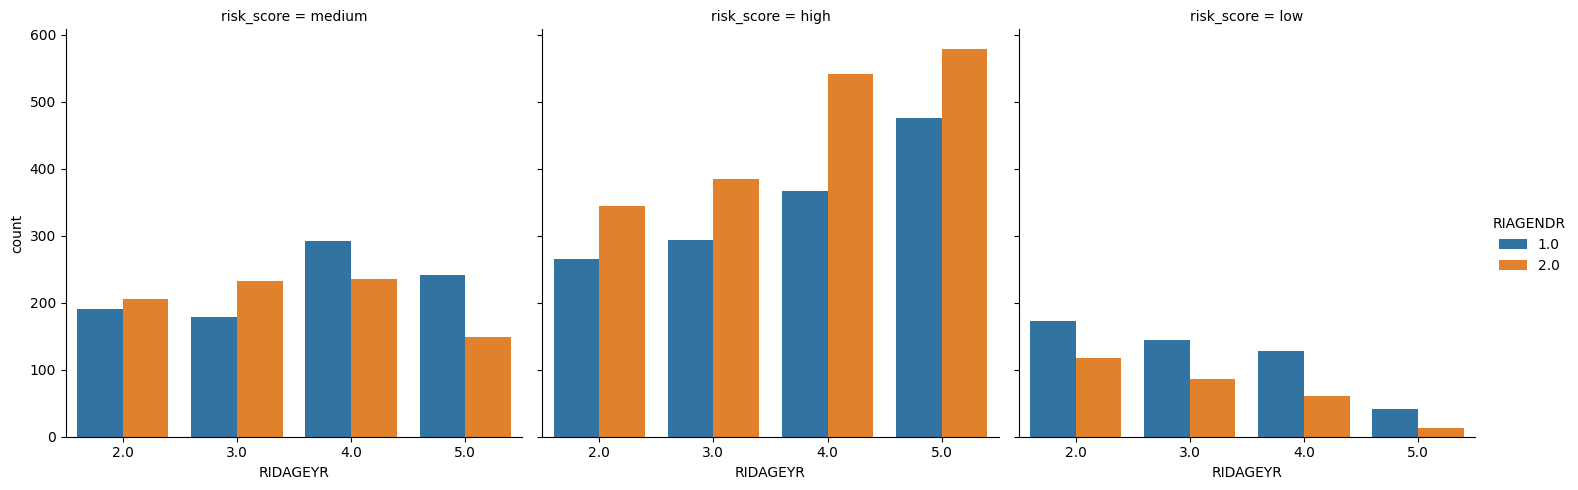

In [68]:
sns.catplot(x="RIDAGEYR", hue="RIAGENDR", col="risk_score", data=num_big_data, kind="count")

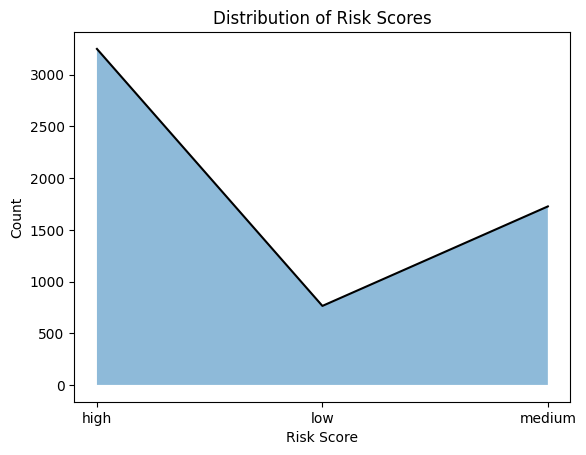

In [69]:
import matplotlib.pyplot as plt

# Count the number of occurrences of each risk_score value
risk_counts = num_big_data['risk_score'].value_counts().sort_index()

# Create an area chart
plt.fill_between(x=risk_counts.index, y1=risk_counts.values, alpha=0.5)
plt.plot(risk_counts.index, risk_counts.values, color='black')

# Set axis labels and title
plt.xlabel('Risk Score')
plt.ylabel('Count')
plt.title('Distribution of Risk Scores')

# Show the chart
plt.show()


In [70]:
import pandas as pd


# Define a dictionary to map the categories to numeric values
category_to_numeric = {
    'low': 1,
    'medium': 2,
    'high': 3
}

# Create a new column with the numeric values
num_big_data['risk_score_num'] = num_big_data['risk_score'].map(category_to_numeric)



<AxesSubplot: xlabel='DBD905', ylabel='risk_score_num-DBD895'>

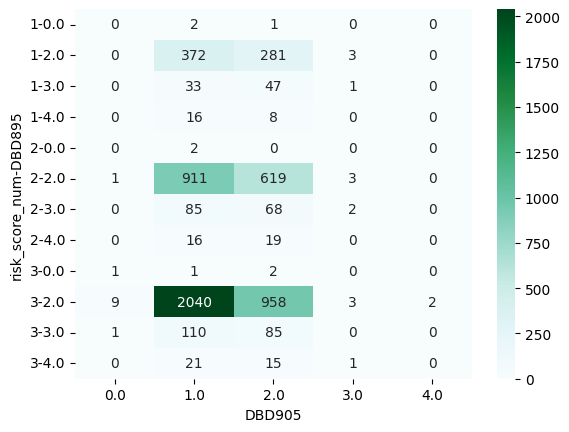

In [71]:
import pandas as pd
import seaborn as sns

# Create contingency table
cont_table = pd.crosstab(index=[num_big_data['risk_score_num'], num_big_data['DBD895']], columns=big_data['DBD905'])

# Create heatmap
sns.heatmap(cont_table, cmap='BuGn', annot=True, fmt='g')


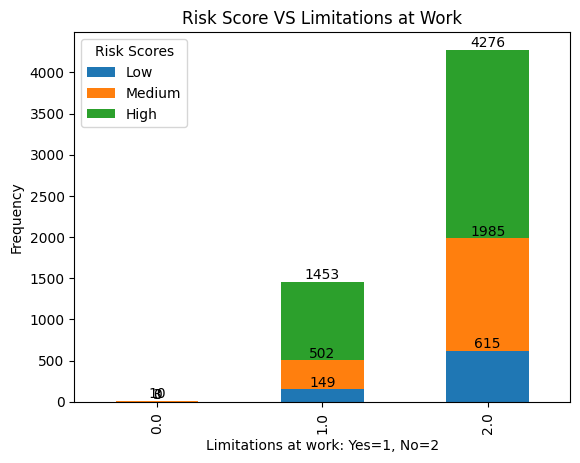

In [74]:
import matplotlib.pyplot as plt
import numpy as np

# Group the data by gender and age and count the values
risk_limit_counts = num_big_data.groupby(['PFQ051', 'risk_score_num'])['PFQ051'].count()

# Create a stacked bar chart using the plot() method
ax = risk_limit_counts.unstack().plot(kind='bar', stacked=True)

# Add labels to the bars
for container in ax.containers:
    ax.bar_label(container)

# Add legend to the plot
plt.legend(title='Risk Scores', labels=['Low', 'Medium', 'High'])

# Add labels and title to the plot
plt.xlabel('Limitations at work: Yes=1, No=2')
plt.ylabel('Frequency')
plt.title('Risk Score VS Limitations at Work')

# Show the plot
plt.show()


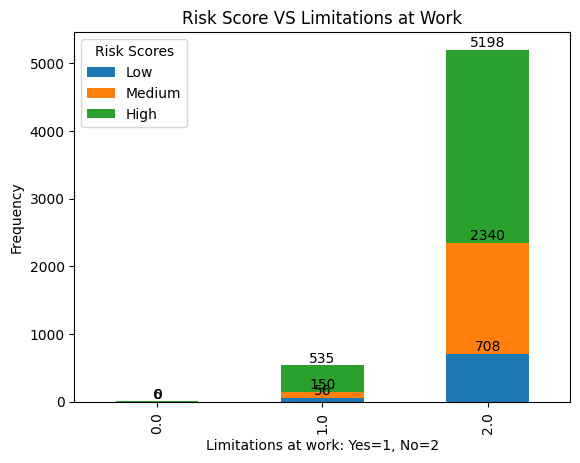

In [75]:
# Group the data by gender and age and count the values
risk_limit_counts = num_big_data.groupby(['PFQ057', 'risk_score_num'])['PFQ057'].count()

# Create a stacked bar chart using the plot() method
ax = risk_limit_counts.unstack().plot(kind='bar', stacked=True)

# Add labels to the bars
for container in ax.containers:
    ax.bar_label(container)

# Add legend to the plot
plt.legend(title='Risk Scores', labels=['Low', 'Medium', 'High'])

# Add labels and title to the plot
plt.xlabel('Limitations at work: Yes=1, No=2')
plt.ylabel('Frequency')
plt.title('Risk Score VS Limitations at Work')

# Show the plot
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ca24e82f-5d1e-44a8-add7-96bfbae31a3d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>